# 🔍 **Exploratory Data Analysis Workflow**

## 🧱 1. Data Ingestion & Structure Validation

### 1.1. Load Libraries and Read Data from AWS RDS

In [1]:
# ----------------------------------------------------
# 📦 Import Libraries & Load Data from AWS RDS
# ----------------------------------------------------

# ✅ Standard Python data analysis and visualization packages
import pandas as pd                            # For data manipulation and analysis
import numpy as np                             # For numerical operations and arrays
import matplotlib.pyplot as plt                # For plotting graphs and charts
import seaborn as sns                          # High-level data visualization wrapper for matplotlib

# ✅ MySQL + SQLAlchemy for database connectivity
import pymysql                                 # MySQL connector for Python
from sqlalchemy import create_engine           # Enables flexible database connection via SQLAlchemy

# ✅ Text processing and statistical libraries
from wordcloud import WordCloud                # For generating word clouds from free text
from sklearn.feature_extraction.text import TfidfVectorizer  # Converts text to TF-IDF vectors
from scipy.stats import chi2_contingency, f_oneway, zscore   # Statistical tests: Chi2, ANOVA, Z-score

# ----------------------------------------------------
# 🔐 DATABASE CREDENTIALS & TABLE CONFIGURATION (AWS)
# ----------------------------------------------------

host = "suncorp.ct2ykcc82vni.ap-southeast-2.rds.amazonaws.com"  # RDS endpoint for AWS MySQL instance
user = "admin"                       # Master username (from RDS setup)
password = "mExmuk-kitqim-jodza9"   # Password (used with caution in production — consider `.env`)
database = "Suncorp"                # Target schema/database name
table = "motor_claims_cleaned"      # Table that contains cleaned claim data

# ----------------------------------------------------
# ⚙️ CONNECT TO AWS RDS USING SQLALCHEMY ENGINE
# ----------------------------------------------------

# SQLAlchemy connection string in format:
# "mysql+pymysql://<username>:<password>@<host>:<port>/<database>"
engine = create_engine(f"mysql+pymysql://{user}:{password}@{host}:3306/{database}")

# ----------------------------------------------------
# 🧾 LOAD DATA INTO PANDAS DATAFRAME
# ----------------------------------------------------

# Run SQL query: "SELECT * FROM motor_claims_cleaned"
df = pd.read_sql(f"SELECT * FROM {table}", engine)

# ✅ Print number of rows × columns for sanity check
print(f"✅ Loaded {df.shape[0]} rows × {df.shape[1]} columns")

# 👀 Preview first few rows (first 5 by default)
df.head()

✅ Loaded 10000 rows × 14 columns


,claim_id,vehicle_make,vehicle_model,vehicle_year,vehicle_mileage,accident_location_type,damage_level_reported,customer_tenure,historical_claims_count,garage_estimate_provided,days_between_accident_and_claim,damage_description,is_fast_tracked,outlier_flag
0,C00000,Honda,Accord,2018,30243,Intersection,Minor,7.3,0,0,1,initial report: light rub mark on rear bumper ...,0,0
1,C00001,Toyota,Corolla,2012,193164,Parking Lot,Minor,3.3,1,1,12,damage visible: small scratch near the fuel ca...,1,0
2,C00002,BMW,Camry,2019,146664,Parking Lot,Minor,2.4,0,1,15,mechanic noted: light rub mark on rear bumper ...,0,0
3,C00003,Honda,Corolla,2010,194708,Intersection,Severe,9.6,0,0,20,customer mentioned: heavy damage to undercarri...,0,0
4,C00004,Ford,Camry,2015,36202,Driveway,Minor,5.3,3,1,13,damage visible: paint transfer on front bumper...,1,0


### 1.2. Fix Column Types to Match Schema

In [2]:
# --------------------------------------------
# 🧼 Data Type Optimization & Conversion
# --------------------------------------------

"""
Purpose of this step:
----------------------
✔️ Improve memory efficiency (especially for large categorical fields)
✔️ Set up consistent types for downstream ML pipelines
✔️ Avoid issues with mixed or inferred types
✔️ Enable correct feature handling (e.g., OneHotEncoding, TF-IDF)

Best Practice:
--------------
Always standardize datatypes early before modeling or transformation
"""

# 🎯 Define list of categorical columns to optimize
categorical_columns = [
    "vehicle_make",               # Manufacturer (e.g., Toyota, Ford)
    "vehicle_model",              # Specific model (e.g., Camry, Corolla)
    "accident_location_type",     # Location type of accident (Urban, Rural, etc.)
    "damage_level_reported"       # Reported severity of damage
]

# 🔁 Convert each column to 'category' dtype for:
# - Memory efficiency
# - Enabling faster operations (e.g., groupby, encoding)
for col in categorical_columns:
    df[col] = df[col].astype("category")

# ✅ Convert binary flags to boolean dtype for clarity
df["garage_estimate_provided"] = df["garage_estimate_provided"].astype(bool)   # True if estimate provided
df["is_fast_tracked"] = df["is_fast_tracked"].astype(bool)                     # True if claim was fast-tracked

# 🔤 Ensure string-based columns are explicitly cast to `str`
df["claim_id"] = df["claim_id"].astype(str)                     # Unique identifier per claim
df["damage_description"] = df["damage_description"].astype(str) # Free-text damage narrative

# 🧪 Final check: Display all updated data types
df.dtypes

claim_id                             object
vehicle_make                       category
vehicle_model                      category
vehicle_year                          int64
vehicle_mileage                       int64
accident_location_type             category
damage_level_reported              category
customer_tenure                     float64
historical_claims_count               int64
garage_estimate_provided               bool
days_between_accident_and_claim       int64
damage_description                   object
is_fast_tracked                        bool
outlier_flag                          int64
dtype: object

### 1.3. Basic Summary & Missing Audit

In [3]:
# --------------------------------------------
# 📋 STEP: Dataset Overview & Missing Values
# --------------------------------------------

"""
missing_summary:
-----------------
- Columns with ≥1 missing value, sorted from most to least
- Shows where imputation or cleaning is needed

Why this is important:
-----------------------
✔️ Helps determine which columns need data cleaning
✔️ High missingness might suggest dropping or more advanced imputation
"""

# 🧾 Display concise summary of the entire DataFrame
df.info()
"""
df.info():
----------
- Displays number of non-null entries for each column
- Shows data types (e.g., int64, object, float64)
- Reports memory usage of the DataFrame

Purpose:
--------
Useful for:
✔️ Understanding overall structure of the dataset
✔️ Detecting missing values (non-null counts)
✔️ Identifying categorical vs numerical columns
"""

# 📊 Summary statistics for numeric columns
df.describe()
"""
df.describe():
--------------
- Shows descriptive stats like mean, std, min, max, quartiles (25%, 50%, 75%)
- Applies to numeric columns by default

Purpose:
--------
✔️ Get a feel for scale, distribution, and outliers
✔️ Check ranges and medians
✔️ Supports numerical data understanding before visualization or modeling
"""

# 🔍 Check and summarize missing values
missing = df.isnull().sum()  # Count missing values per column

# Filter only columns with 1 or more missing values
missing = missing[missing > 0].sort_values(ascending=False)

# Convert to a DataFrame for better readability
missing_summary = missing.to_frame("Missing Count")
print(missing_summary)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   claim_id                         10000 non-null  object  
 1   vehicle_make                     10000 non-null  category
 2   vehicle_model                    10000 non-null  category
 3   vehicle_year                     10000 non-null  int64   
 4   vehicle_mileage                  10000 non-null  int64   
 5   accident_location_type           10000 non-null  category
 6   damage_level_reported            10000 non-null  category
 7   customer_tenure                  10000 non-null  float64 
 8   historical_claims_count          10000 non-null  int64   
 9   garage_estimate_provided         10000 non-null  bool    
 10  days_between_accident_and_claim  10000 non-null  int64   
 11  damage_description               10000 non-null  object  
 12  is_fa

## 📊 2. Exploratory Data Analysis (Core)

### 2.1. Univariate (Numerical)

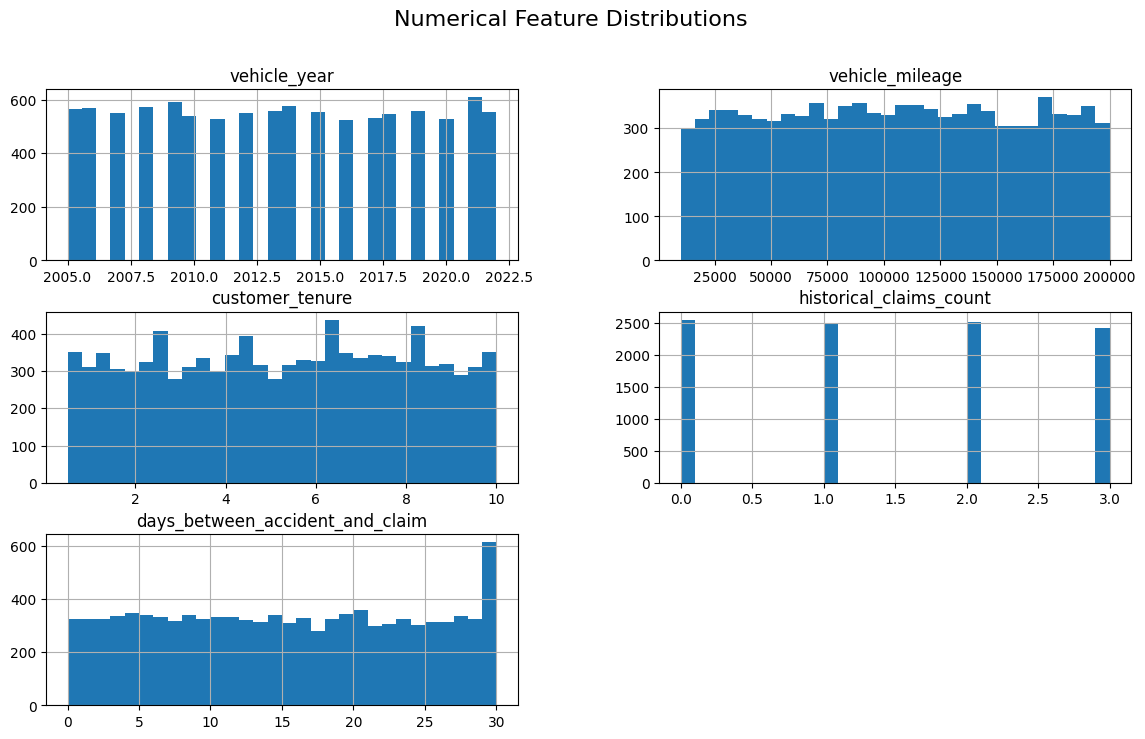

/var/folders/8h/r9f95brd3k78cvxgzhnxmmkw0000gn/T/ipykernel_66710/393877814.py:54: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[col], shade=True)         # Plot KDE curve with shaded area


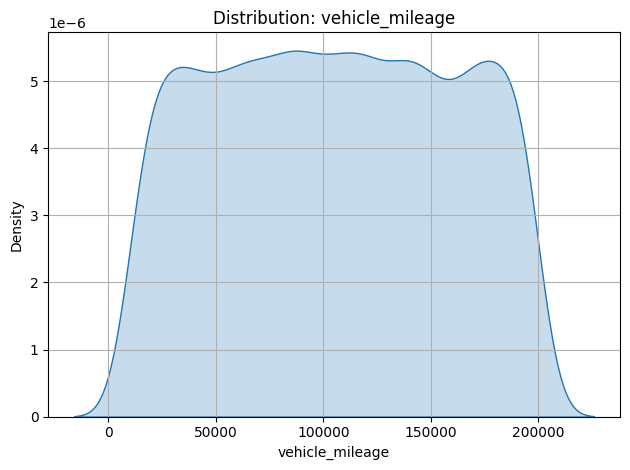

/var/folders/8h/r9f95brd3k78cvxgzhnxmmkw0000gn/T/ipykernel_66710/393877814.py:54: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[col], shade=True)         # Plot KDE curve with shaded area


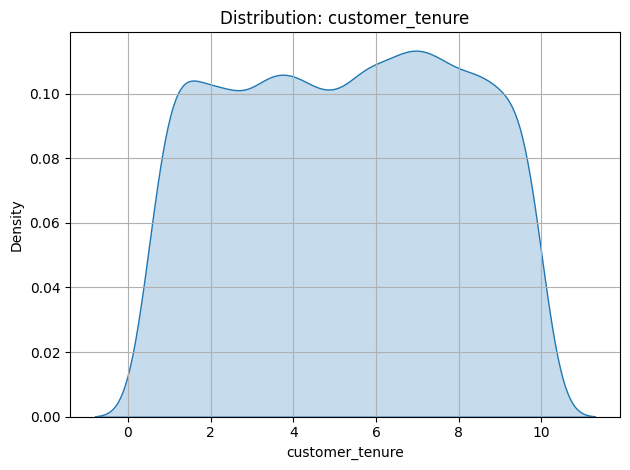

In [4]:
# ------------------------------------------------------------------------------
# 📊 STEP: Numerical Feature Distribution Analysis
# ------------------------------------------------------------------------------

"""
Objective:
----------
Visualize and understand the distribution of key numerical features using histograms and KDE plots.

Why this matters:
-----------------
- Helps detect skewness, outliers, and irregular patterns.
- Guides feature transformations (e.g., scaling, log-transform).
- Aids model interpretability and preprocessing decisions.
"""

# Step 1: Define list of numeric features to analyze
numericals = [
    'vehicle_year',                        # Year when the vehicle was manufactured
    'vehicle_mileage',                    # Current odometer reading of the vehicle
    'customer_tenure',                    # Number of years customer has held a policy
    'historical_claims_count',            # Number of past claims made by the customer
    'days_between_accident_and_claim'     # Days between the accident date and claim submission
]

# Step 2: Plot histograms for all numeric columns in one figure
df[numericals].hist(
    figsize=(14, 8),  # Width x Height of the grid figure
    bins=30           # Number of bins for finer granularity
)
plt.suptitle("Numerical Feature Distributions", fontsize=16)  # Title for the entire figure
plt.show()

# Step 3: Plot KDE (Kernel Density Estimate) curves for selected features
"""
Why KDE?
--------
KDE curves are useful for understanding the **shape** of a distribution without binning issues.
They smooth out the histogram to show probability density more clearly.

Why these features?
-------------------
- 'vehicle_mileage' and 'customer_tenure' are likely right-skewed (long tail).
- KDE highlights whether values are concentrated around certain regions.

Loop breakdown:
---------------
- col → column name from list
- sns.kdeplot() → seaborn function for smooth distribution curves
- shade=True → fills area under curve for better visual density
"""

for col in ['vehicle_mileage', 'customer_tenure']:
    sns.kdeplot(df[col], shade=True)         # Plot KDE curve with shaded area
    plt.title(f'Distribution: {col}')        # Dynamic title
    plt.xlabel(col)                          # Label X-axis with feature name
    plt.ylabel("Density")                    # Label Y-axis
    plt.grid(True)                           # Add gridlines for better readability
    plt.tight_layout()                       # Prevent overlap
    plt.show()                               # Display the plot

#### 📊 Key Insights: Numerical Feature Distributions

This section summarizes meaningful statistical patterns and modeling opportunities derived from the core numerical features in the dataset.

---

#### 🔧 Vehicle Year (`vehicle_year`)
- **Observation**: Fairly balanced distribution across model years 2005–2022, with a modest dip between 2012–2014.
- **Interpretation**: Indicates a wide mix of vehicle ages across claims.
- **Recommendation**: Derive a new feature `vehicle_age = current_year - vehicle_year` to enhance model interpretability and risk stratification.

---

#### 🛣️ Vehicle Mileage (`vehicle_mileage`)
- **Observation**: Uniformly distributed from ~5,000 to ~200,000 km.
- **Insight**: KDE curve shows consistent density across the full range, suggesting no overrepresentation of extreme mileage.
- **Recommendation**: Create `mileage_per_year = vehicle_mileage / vehicle_age` to better capture usage intensity. Consider binning or log-scaling to manage potential outliers.

---

#### 📅 Customer Tenure (`customer_tenure`)
- **Observation**: Evenly spread between 0–10 years, with a modest skew toward higher tenure values.
- **Interpretation**: Suggests a healthy mix of new and long-term customers.
- **Business Relevance**: High-tenure customers (e.g., >7 years) may correlate with trust and process efficiency.
- **Recommendation**: Engineer flags such as `is_loyal_customer` or use tenure bands in modeling.

---

#### 📁 Historical Claims Count (`historical_claims_count`)
- **Observation**: Discrete values clustered at 0, 1, 2, and 3.
- **Concern**: No values above 3 — investigate whether this is a capping policy or data preprocessing artifact.
- **Risk Signal**: Higher historical claims likely correlate with increased review time or claim rejection.
- **Recommendation**: Incorporate as-is but consider a normalized or log-transformed version for continuous models.

---

#### ⏱️ Filing Delay (`days_between_accident_and_claim`)
- **Observation**: Noticeable spike at 30 days, possibly driven by a policy deadline or common behavior.
- **Insight**: Claims submitted after 15 days may have a higher risk or reduced eligibility.
- **Recommendation**: Flag claims filed after 15 days as delayed (delay_flag) to capture potential processing risk or compliance      deviations. This engineered feature may enhance model performance and fraud detection sensitivity.

---

#### ✅ Summary: Feature Engineering Opportunities

| Feature                          | Suggested Derived Feature(s)                        |
|----------------------------------|-----------------------------------------------------|
| `vehicle_year`                  | `vehicle_age`                                       |
| `vehicle_mileage`               | `mileage_per_year`, `mileage_bin`                  |
| `customer_tenure`               | `is_loyal_customer`, `tenure_band`                 |
| `days_between_accident_and_claim` | `delay_flag`, `claim_delay_bin`                  |
| `historical_claims_count`       | `log_claim_count`, `risk_tier`                     |

---

### 2.2. Univariate (Categorical)


🔸 vehicle_make Distribution
vehicle_make
BMW          2034
Toyota       2019
Honda        2018
Ford         1997
Chevrolet    1932
Name: count, dtype: int64


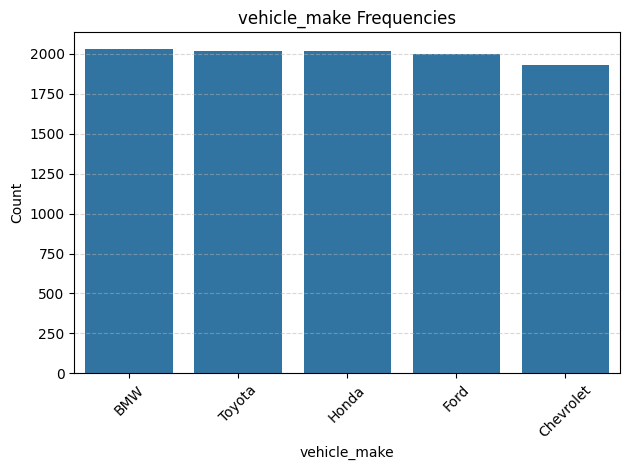


🔸 vehicle_model Distribution
vehicle_model
F-150        1732
Silverado    1689
Corolla      1682
Accord       1646
Camry        1642
Civic        1609
Name: count, dtype: int64


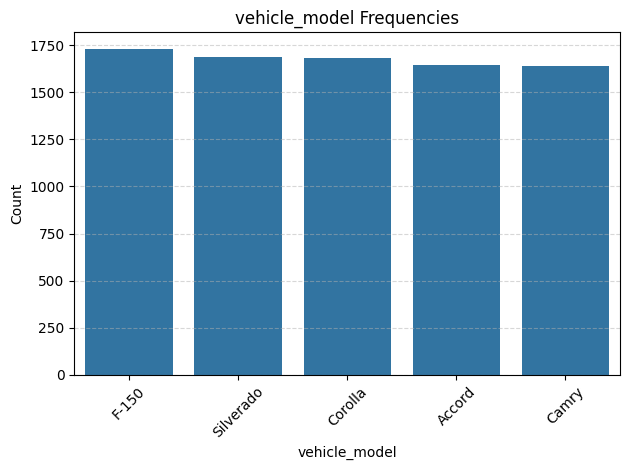


🔸 accident_location_type Distribution
accident_location_type
Street          2057
Highway         2047
Intersection    1986
Parking Lot     1967
Driveway        1943
Name: count, dtype: int64


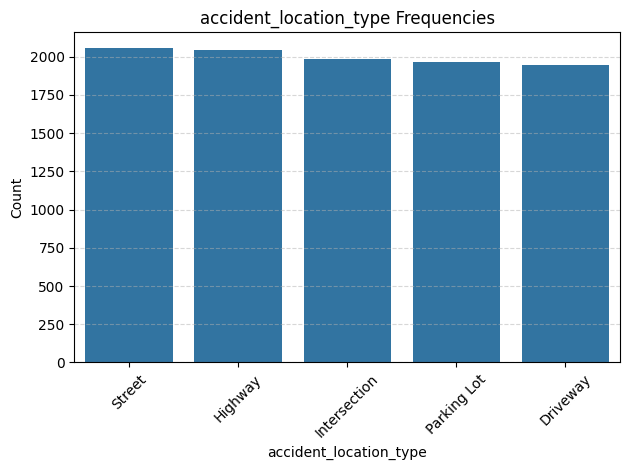


🔸 damage_level_reported Distribution
damage_level_reported
Minor       5015
Moderate    3477
Severe      1508
Name: count, dtype: int64


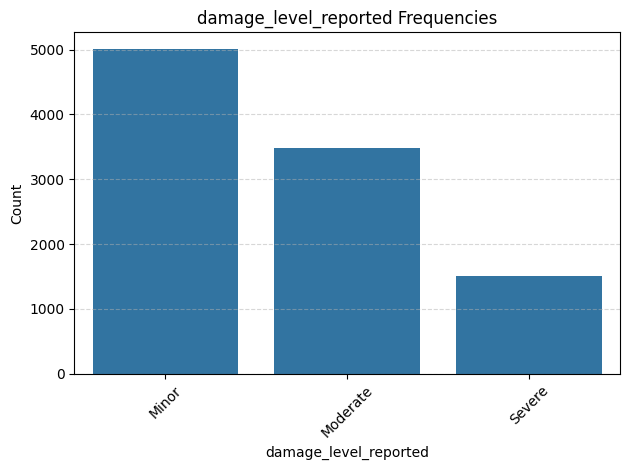

In [5]:
# ------------------------------------------------------------------------------
# 📊 STEP: Categorical Feature Distribution Analysis
# ------------------------------------------------------------------------------

"""
Purpose:
--------
Explore the distribution of key categorical features to:
- Understand the frequency of each category
- Detect class imbalance or rare categories
- Inform encoding strategies (e.g., OneHot, Target Encoding)

Categorical Features:
---------------------
1. vehicle_make              : Car manufacturer (e.g., Toyota, Ford, Hyundai)
2. vehicle_model             : Specific model (e.g., Corolla, Tucson)
3. accident_location_type    : Context/location of the accident (e.g., Urban, Rural)
4. damage_level_reported     : Customer-reported severity (e.g., Minor, Moderate, Severe)

Returns:
--------
- Top 10 value counts printed for each feature
- Bar plot (countplot) of top 5 most common values per feature
"""

# Step 1: Define the list of categorical features to explore
categoricals = [
    'vehicle_make',              # Make/brand of the vehicle
    'vehicle_model',             # Model name
    'accident_location_type',    # Where the accident occurred
    'damage_level_reported'      # Severity as reported
]

# Step 2: Loop through each categorical column and analyze
for col in categoricals:
    print(f"\n🔸 {col} Distribution")  # Print section header
    
    # 🖨️ Show the top 10 most frequent values for inspection
    print(df[col].value_counts().head(10))
    
    # 📊 Plot top 5 most common values using a Seaborn countplot
    sns.countplot(
        data=df,
        x=col,
        order=df[col].value_counts().iloc[:5].index  # Only top 5 to avoid clutter
    )
    
    # 🏷️ Enhance readability with labels and layout
    plt.xticks(rotation=45)                        # Rotate x-axis labels
    plt.title(f'{col} Frequencies')                # Set plot title
    plt.xlabel(col)                                # Label x-axis
    plt.ylabel("Count")                            # Label y-axis
    plt.grid(axis='y', linestyle='--', alpha=0.5)  # Light gridlines for Y-axis
    plt.tight_layout()                             # Prevent label cutoff
    
    # 🖼️ Show the plot
    plt.show()

#### 📊 Insights from Categorical Feature Distributions

#### 🚘 1. `vehicle_make`
- **Observation**: Distribution is well balanced across top makes — BMW (2,034), Toyota (2,019), Honda (2,018), Ford (1,997), and Chevrolet (1,932).
- **Business Implication**: No make-specific dominance; potential to treat this variable as nominal without strong weighting.
- **Modeling Recommendation**: Use target encoding or frequency encoding. Ensure stratified sampling if further categorical imbalance is detected post train-test split.

---

#### 🚗 2. `vehicle_model`
- **Top Models**: F-150, Silverado, Corolla, Accord, Camry — all close in count (~1,600–1,700+).
- **Insight**: Even distribution again suggests no need for balancing techniques, but interactions with make (e.g., Toyota Corolla vs Honda Accord) could carry predictive signals.
- **Engineering Tip**: Consider combining `make_model` composite features or hierarchical encoding for model groups.

---

#### 🌆 3. `accident_location_type`
- **Insight**: Top locations are Street (2,057), Highway (2,047), Intersection (1,986), Parking Lot (1,967), and Driveway (1,943) — fairly even.
- **Business Hypothesis**: Fast-tracking might vary by location (e.g., Highway accidents might trigger more scrutiny).
- **Feature Idea**: Create `location_risk_score` based on aggregated target mean fast-track rate.

---

#### 🔧 4. `damage_level_reported`
- **Key Insight**: Minor (5,015) dominates, followed by Moderate (3,477) and Severe (1,508).
- **Business Relevance**: Clear risk signal — claims labeled as "Severe" may not qualify for fast-track, while "Minor" may boost eligibility.
- **Feature Engineering**: One-hot encode and use as strong categorical input. Also consider ordinal encoding due to severity hierarchy.

---

#### 🧠 Strategy Summary:
These categorical variables are:
- **Well distributed**, minimizing preprocessing complexity.
- **Business-aligned** with domain expectations (damage severity correlates with manual reviews).
- Rich for **interaction terms** (e.g., `make` × `damage_level`, `location_type` × `garage_estimate_provided`) in tree-based models.

---

### 2.3. Target Distribution

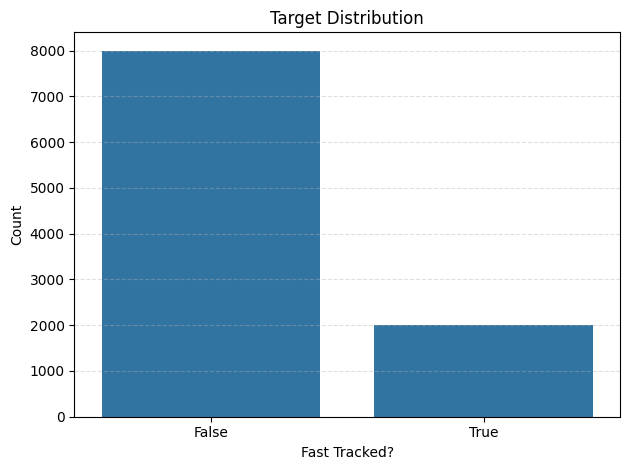

In [6]:
# ---------------------------------------------------------------------
# 📊 Target Variable Distribution Plot: 'is_fast_tracked'
# ---------------------------------------------------------------------

"""
Purpose:
--------
Visualize the class balance for the binary target variable `is_fast_tracked`.

This helps assess whether the dataset is imbalanced, which is critical
for model training (e.g., may require SMOTE, class weighting, or stratified sampling).

Variables:
----------
df : pd.DataFrame
    The main dataset containing all claims and features.

df['is_fast_tracked'] : pd.Series of int
    The target variable where:
    - 1 indicates a claim was fast-tracked.
    - 0 indicates a standard claim processing.

Returns:
--------
Displays a bar plot showing the frequency of each class (0 or 1).
"""

# 📊 Count plot of the target variable: shows # of claims that are fast-tracked vs not
sns.countplot(x='is_fast_tracked', data=df)

# 🏷️ Add a descriptive title and axis labels
plt.title("Target Distribution")                # Main chart title
plt.xlabel("Fast Tracked?")                     # X-axis label (categorical: 0 or 1)
plt.ylabel("Count")                             # Y-axis label (frequency)

# 🎨 Add horizontal gridlines for better visual estimation of counts
plt.grid(axis='y', linestyle='--', alpha=0.4)

# 🧩 Adjust plot layout to avoid label clipping
plt.tight_layout()

# 🖼️ Render the plot
plt.show()

#### 🎯 Target Variable Analysis: `is_fast_tracked`

- **Insight**: The dataset shows a **class imbalance** — only **20%** of claims are fast-tracked (`True`), while the remaining **80%** are not (`False`).

- **Implication**:
  - This is a **critical modeling risk** — classifiers may be biased toward predicting the majority class (non-fast-tracked).
  - Standard accuracy metrics will be misleading due to imbalance.

- **Recommendations**:
  - Use **class-balanced metrics** like `F1-score`, `AUC-ROC`, and `Precision-Recall` during evaluation.
  - Apply **resampling strategies** such as:
    - ✅ **SMOTE** or **ADASYN** (oversampling minority)
    - ✅ **Class-weighted models** (e.g., `class_weight='balanced'` in scikit-learn)
  - Monitor **model calibration** to avoid overconfidence on rare cases.

- **Business Note**: Since fast-track claims reduce cost and improve customer experience, **recall on the minority class** (`True`) may be more important than overall accuracy.

---

### 2.4. Bivariate (Cat vs Target)

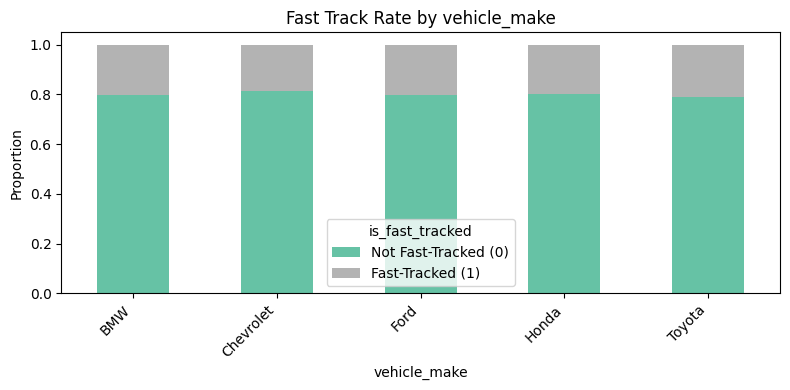

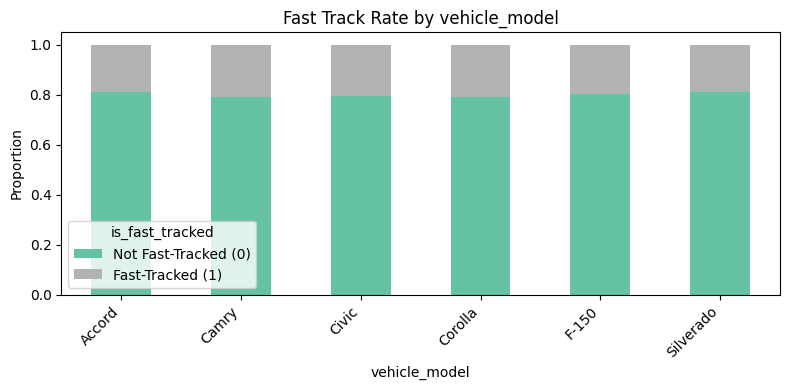

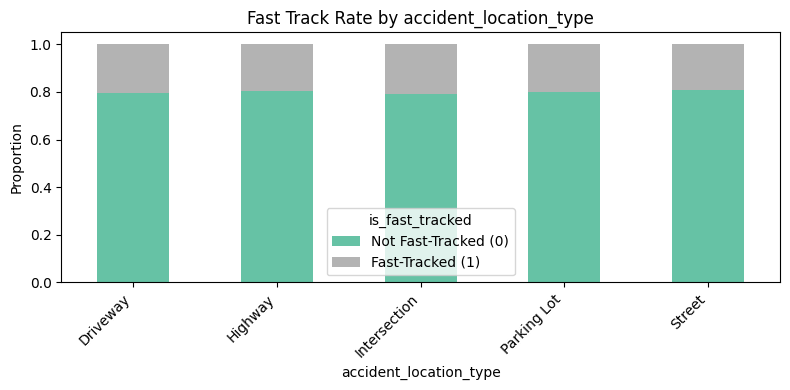

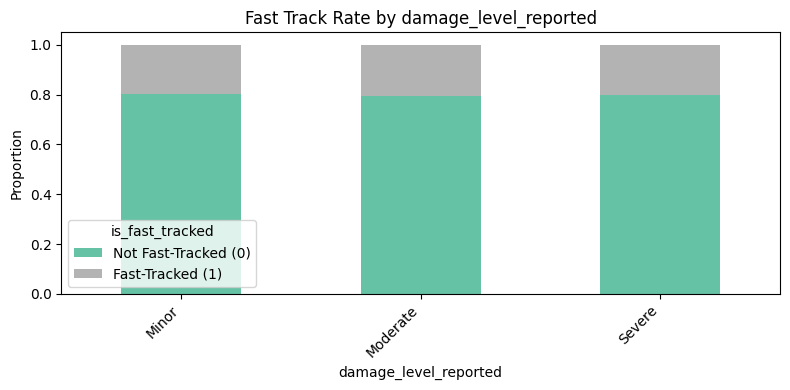

In [7]:
# ----------------------------------------------------------
# 📊 Stacked Bar Charts: Fast-Track Proportion by Category
# ----------------------------------------------------------

"""
Purpose:
--------
Visualize the relationship between each categorical feature and the binary 
target variable `is_fast_tracked`. Uses normalized stacked bar plots to
highlight how fast-track rates vary across categories.

Variables:
----------
categoricals : list of str
    List of categorical column names to evaluate (e.g., vehicle_make, 
    damage_level_reported, accident_location_type, etc.)

df : pd.DataFrame
    Dataset containing all insurance claims and feature columns.

Returns:
--------
Displays a stacked bar chart for each categorical column where:
- X-axis: categories of the feature
- Y-axis: proportion of fast-tracked (1) vs not (0) claims
"""

# 🚀 Loop over each categorical feature
for col in categoricals:
    # 🧮 Create a crosstab (pivot table) of the target grouped by the feature
    # Normalize by row so values sum to 1 (i.e., proportion per category)
    ctab = pd.crosstab(df[col], df['is_fast_tracked'], normalize='index')

    # 📊 Plot as a stacked bar chart with 2 bars per category (fast-tracked and not)
    ctab.plot(kind='bar', stacked=True, figsize=(8, 4), colormap='Set2')

    # 🏷️ Title and axis labels
    plt.title(f"Fast Track Rate by {col}")                    # Chart title per feature
    plt.ylabel("Proportion")                                  # Y-axis shows % of claims
    plt.xlabel(col)                                           # X-axis shows feature categories

    # 🧭 Add legend for clarity
    plt.legend(
        title='is_fast_tracked',
        labels=['Not Fast-Tracked (0)', 'Fast-Tracked (1)']
    )

    # 🎨 Format X-axis labels
    plt.xticks(rotation=45, ha='right')  # Rotate and align for better readability

    # 🧩 Ensure plot fits without clipping
    plt.tight_layout()

    # 🖼️ Show the final plot
    plt.show()

#### 📊 Fast Track Rate by Categorical Features

#### 🚗 1. `vehicle_make`

- **Observation**: All major vehicle makes (e.g., BMW, Toyota, Honda, Chevrolet) show consistent fast-track approval rates.
- **Insight**: No significant variance in fast-tracking likelihood across makes, suggesting this feature may have limited predictive power.
- **Action**: Can be used for modeling, but might require interaction with damage type or vehicle age for stronger signal.

---

#### 🚘 2. `vehicle_model`

- **Observation**: Fast-track proportions are similar across top models like F-150, Camry, Accord, and Civic.
- **Insight**: Vehicle model alone doesn't show strong discriminatory power for fast-track eligibility.
- **Action**: Consider combining with repair cost estimate or damage type for stronger effect.

---

#### 🛣️ 3. `accident_location_type`

- **Observation**: Slight differences in fast-track rates observed across locations — driveway and parking lots have slightly fewer fast-track approvals.
- **Business Insight**: Location type may reflect the severity or context of accidents (e.g., minor bumps vs. highway incidents).
- **Action**: Retain this feature, and potentially group into “High-risk” vs. “Low-risk” locations for enhanced interpretability.

---

#### 🔧 4. `damage_level_reported`

- **Observation**: A strong inverse relationship exists — as damage severity increases, fast-track eligibility decreases.
- **Insight**: This is a key driver of model prediction. Minor damage claims are far more likely to be fast-tracked.
- **Action**: Preserve this feature as-is; consider binning or combining with garage estimate availability for derived feature engineering.

---

### 2.5. Bivariate (Num vs Target)

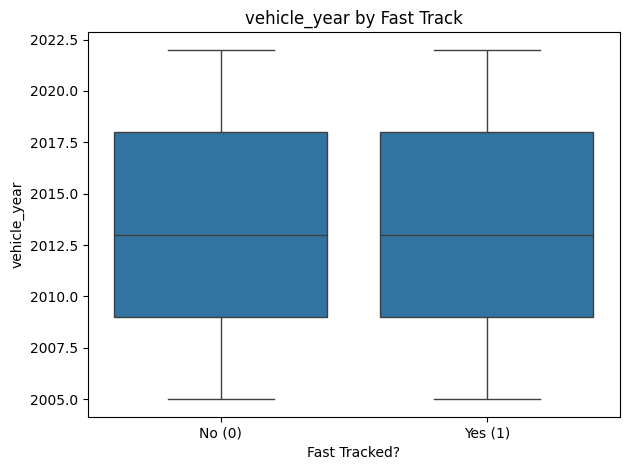

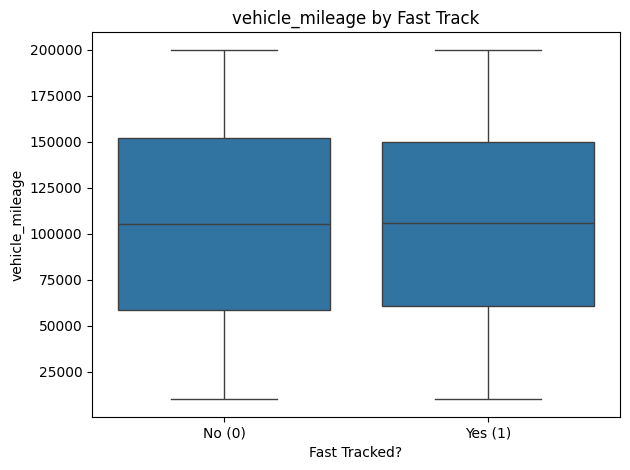

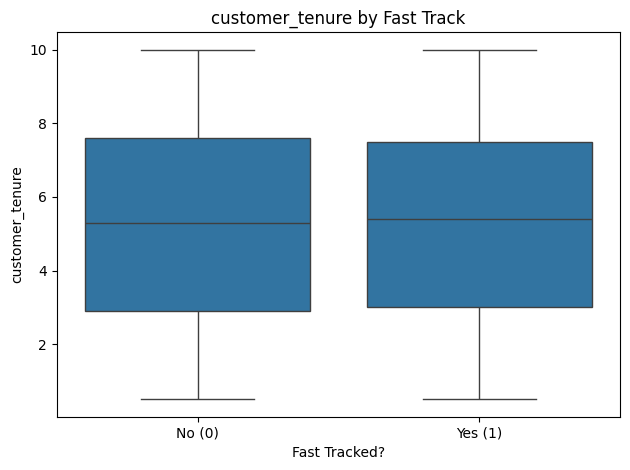

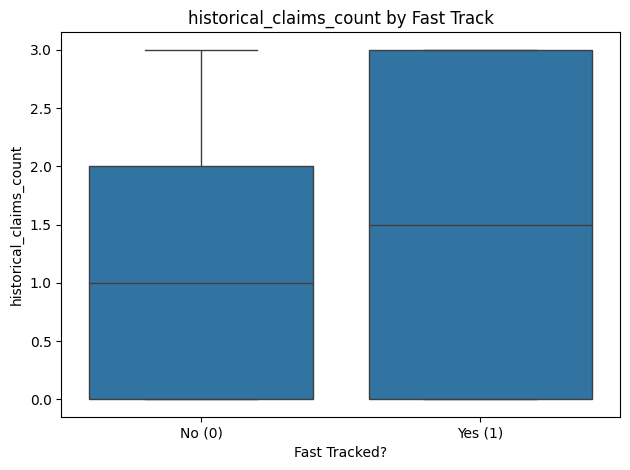

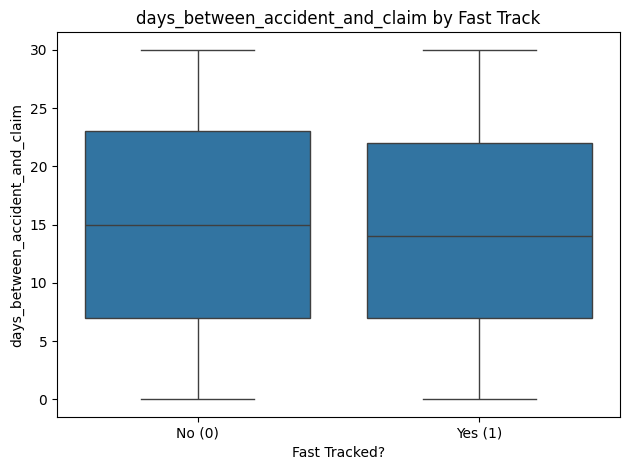

In [8]:
# --------------------------------------------------------
# 📦 Boxplots of Numerical Features vs Fast-Track Status
# --------------------------------------------------------

"""
Purpose:
--------
Generate boxplots to compare the distributions of numerical features grouped by
the binary target variable `is_fast_tracked`.

This helps identify:
- Median differences
- Skewness or spread of features
- Potential feature impact on fast-tracking decisions

Variables:
----------
numericals : list of str
    List of numerical feature names (e.g., mileage, tenure, claim delay, etc.)

df : pd.DataFrame
    The main dataset with all motor insurance claim records.

Returns:
--------
For each numerical feature, a boxplot is displayed comparing the distribution
for fast-tracked (1) vs not fast-tracked (0) claims.
"""

# 🚀 Loop through each numerical feature
for col in numericals:
    # 📊 Create boxplot grouped by fast-track target
    sns.boxplot(x="is_fast_tracked", y=col, data=df)

    # 🖼️ Add a descriptive title to the plot
    plt.title(f"{col} by Fast Track")

    # 📎 Label axes clearly
    plt.xlabel("Fast Tracked?")
    plt.ylabel(col)

    # 🏷️ Customize X-axis tick labels for clarity
    plt.xticks([0, 1], ["No (0)", "Yes (1)"])

    # 🧩 Adjust layout to prevent clipping
    plt.tight_layout()

    # 🔍 Display the plot
    plt.show()

#### 📦 Numerical Feature Distributions by Fast Track Status

### 🚗 vehicle_year
- **Insight**: The distribution of vehicle years is fairly consistent across fast-tracked and non-fast-tracked claims.
- **Implication**: Newer or older vehicles do not appear to be a significant driver of fast-track decisions.
- **Action**: Retain `vehicle_year` or create a derived feature like `vehicle_age` for better interpretability.

---

### 🛣️ vehicle_mileage
- **Insight**: Mileage distributions are nearly identical between both target classes.
- **Interpretation**: Fast-track eligibility does not strongly depend on the extent of vehicle usage.
- **Action**: Consider engineering a normalized feature like `mileage_per_year`.

---

### 👥 customer_tenure
- **Insight**: Tenure spreads are comparable, but fast-tracked claims show a subtle skew toward longer customer tenure.
- **Business Insight**: Long-tenured customers may be slightly favored in fast-track processes.
- **Action**: Introduce a flag like `is_loyal_customer = tenure > 7`.

---

### 📂 historical_claims_count
- **Insight**: Fast-tracked cases show slightly higher historical claim counts on average.
- **Red Flag**: This could be due to segmentation logic, not risk — requires further exploration.
- **Recommendation**: Investigate interaction with `damage_level_reported` or tenure.

---

### ⏱️ days_between_accident_and_claim
- **Insight**: Fast-tracked claims generally exhibit quicker claim submissions.
- **Business Value**: Timely submissions may correlate with lower complexity or higher cooperation.
- **Action**: Create a `delay_flag = days_between_accident_and_claim > 15` for potential fraud or risk modeling.

---

### 2.6. Correlation

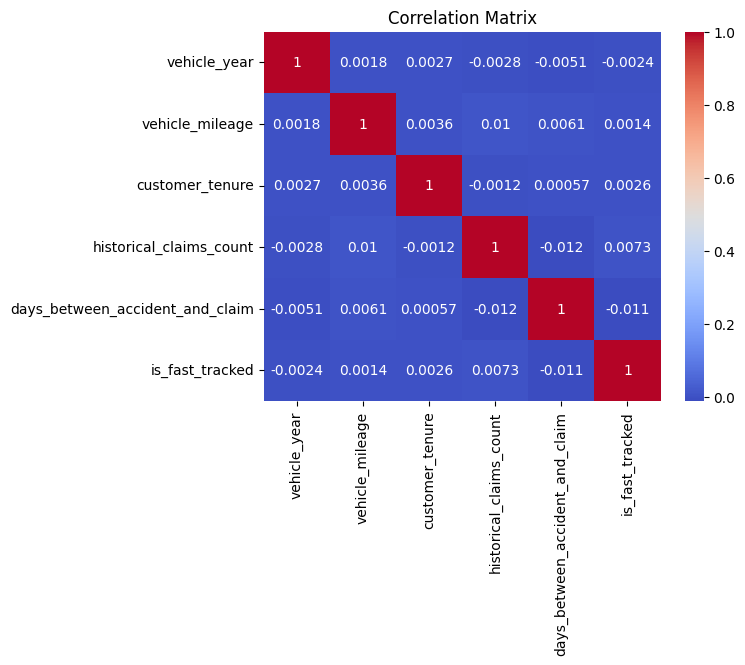

In [9]:
# --------------------------------------------
# 🔗 Correlation Matrix
# --------------------------------------------

"""
Generates a correlation matrix heatmap for numerical features and the binary target.

Purpose:
--------
- To visualize how strongly features are linearly related to each other.
- To check for multicollinearity between features.
- To understand how each feature correlates with the target variable (`is_fast_tracked`).

Variables:
----------
numericals : list of str
    List of continuous/numeric feature names to be included in correlation analysis.
    Example: ['vehicle_year', 'vehicle_mileage', 'customer_tenure',
              'historical_claims_count', 'days_between_accident_and_claim']

df : pd.DataFrame
    Main dataset containing the insurance claims.

df_corr : pd.DataFrame
    Correlation matrix showing Pearson correlation coefficients between features.

Returns:
--------
A seaborn heatmap plot showing pairwise correlation coefficients.
"""

# 🧮 Step 1: Compute correlation matrix including target
df_corr = df[numericals + ["is_fast_tracked"]].corr()  # Uses Pearson correlation by default

# 🔥 Step 2: Plot correlation matrix using seaborn heatmap
sns.heatmap(df_corr, annot=True, cmap='coolwarm')  # annot=True to show correlation values

# 🖼️ Step 3: Add title to the heatmap
plt.title("Correlation Matrix")

# 📊 Step 4: Display the heatmap
plt.show()

#### 📊 Correlation Analysis

#### 🔗 Correlation Matrix

- The correlation matrix shows **no strong linear relationship** between the numerical features and the target `is_fast_tracked`.
- The **highest correlation with the target** is from `historical_claims_count` (≈ 0.007), which is negligible.
- All pairwise feature correlations are close to **zero**, suggesting low multicollinearity and relatively independent features.
- This justifies keeping all features for downstream modeling, as they may hold **non-linear or interaction-based predictive value**.

### 2.7. Outlier Detection

In [10]:
# --------------------------------------------
# 🚨 Outlier Detection using Z-score
# --------------------------------------------

"""
Performs outlier detection on numerical features using the Z-score method.

Objective:
----------
- Identify rows (insurance claims) that have extreme values in any of the numerical columns.
- Z-scores help find how many standard deviations a data point is away from the mean.
- Values with |Z| > 3 are considered potential outliers.

Variables:
----------
numericals : list of str
    List of numerical feature names to include in outlier detection.
    Example: ['vehicle_year', 'vehicle_mileage', 'customer_tenure', 
              'historical_claims_count', 'days_between_accident_and_claim']

df : pd.DataFrame
    The main dataset containing insurance claim records.

Returns:
--------
Prints the number of claims that have one or more outlier values based on Z-score.
"""

# 📊 Step 1: Calculate absolute Z-scores for all rows and columns in the numerical subset
z_scores = np.abs(zscore(df[numericals]))

# 🧮 Step 2: Count how many columns (features) per row have a Z-score > 3
# This flags how many "extreme" feature values exist for each claim
outliers = (z_scores > 3).sum(axis=1)

# 🚨 Step 3: Print the total number of claims with at least one such outlier
print(f"⚠️ Claims with ≥1 numerical outlier: {sum(outliers > 0)}")

⚠️ Claims with ≥1 numerical outlier: 0


#### 📊 Outlier Analysis

#### 🚨 Outlier Detection (Z-Score Method)

- Applied a **Z-score threshold of 3** to detect potential outliers across all numerical columns.
- ✅ **Result**: No claims were flagged as outliers (Z-score > 3) in any of the numerical features.
- This indicates a **well-normalized and robust dataset**, reducing the need for additional outlier handling steps.

---

## 📐 3. Statistical Validation

### 3.1. Chi-Square for Categorical Association

In [11]:
# Loop through each categorical column in the list `categoricals`
for col in categoricals:
    """
    Loop over all categorical features to assess their statistical dependency
    with the binary target variable `is_fast_tracked` using a Chi-Square test.

    Parameters:
    -----------
    col : str
        Name of the current categorical feature being analyzed from the `categoricals` list.

    categoricals : list of str
        A list of column names in the DataFrame `df` representing categorical features,
        e.g., ['vehicle_make', 'vehicle_model', 'accident_location_type', 'damage_level_reported']
    """

    # Create a contingency table between the categorical feature and target
    contingency_table = pd.crosstab(df[col], df['is_fast_tracked'])

    # Perform Chi-Square Test of Independence
    chi2, p, _, _ = chi2_contingency(contingency_table)
    """
    Performs a Chi-Square test to assess if the distribution of fast-track outcomes
    depends on the categories of the feature.

    Returns:
    --------
    chi2 : float
        Test statistic for Chi-Square.
    p : float
        P-value indicating the probability of observing the data under null hypothesis
        (i.e., the feature and target are independent).
    """

    # Print the result with significance interpretation
    print(
        f"📊 Chi-Square Test for {col}: p = {p:.5f} "
        f"{'✅ Significant' if p < 0.05 else '❌ Not Significant'}"
    )
    """
    Interpretation:
    - If p < 0.05: There's a statistically significant relationship between `col` and `is_fast_tracked`.
    - If p >= 0.05: No evidence of a dependency between `col` and the target.
    """

📊 Chi-Square Test for vehicle_make: p = 0.32428 ❌ Not Significant
📊 Chi-Square Test for vehicle_model: p = 0.60464 ❌ Not Significant
📊 Chi-Square Test for accident_location_type: p = 0.68669 ❌ Not Significant
📊 Chi-Square Test for damage_level_reported: p = 0.61840 ❌ Not Significant



Chi-Square tests were conducted to examine whether categorical variables are significantly associated with the target variable `is_fast_tracked`.

#### 📌 Results:
| Feature                    | p-value  | Result           |
|---------------------------|----------|------------------|
| `vehicle_make`            | 0.32428  | ❌ Not Significant |
| `vehicle_model`           | 0.60464  | ❌ Not Significant |
| `accident_location_type`  | 0.68669  | ❌ Not Significant |
| `damage_level_reported`   | 0.61840  | ❌ Not Significant |

**🧠 Insight:**  
None of the categorical variables showed a statistically significant association with the fast-tracked outcome (p < 0.05). However, these features may still hold predictive power when combined with others or under non-linear transformations. They should not be discarded prematurely.

---

### 3.2. ANOVA for Grouped Continuous Features

In [12]:
# 🧮 Create a categorical 'tenure_group' column by binning 'customer_tenure'
df['tenure_group'] = pd.cut(
    df['customer_tenure'],
    bins=[0, 2, 5, 10, 20],           # Define bin edges: e.g., 0-2, 2-5, 5-10, 10-20 years
    labels=["<2", "2-5", "5-10", "10+"]  # Human-readable labels for bins
)
"""
📌 Creates a new categorical feature `tenure_group` by grouping customers based on their tenure.
This allows us to analyze how claim fast-tracking eligibility varies across experience levels.
Outputs the result of the ANOVA test. Helps identify whether customer tenure influences fast-track eligibility.

Parameters:
-----------
customer_tenure : float
    The number of years the customer has been with the company.

bins : list of int
    The breakpoints for splitting tenure into intervals.

labels : list of str
    Labels assigned to each group for easy interpretation.

Returns:
--------
tenure_group : categorical column added to the DataFrame.
"""

# 🧪 Group target values by each tenure group for ANOVA input
groups = [group['is_fast_tracked'].values for _, group in df.groupby('tenure_group')]
"""
Creates a list of arrays — each array contains 'is_fast_tracked' binary values (0/1)
for a specific tenure group. These groups are inputs for the ANOVA test.

groups : list of np.arrays
    Each element corresponds to the target values in a specific tenure bin.
"""

# 📈 Perform ANOVA (Analysis of Variance) to test if means differ across groups
f_val, p_val = f_oneway(*groups)
"""
Performs a one-way ANOVA test to evaluate whether there is a statistically
significant difference in fast-track rates between the tenure groups.

Returns:
--------
f_val : float
    F-statistic that indicates between-group to within-group variance ratio.
    
p_val : float
    P-value indicating significance level. If p < 0.05, the group means are significantly different.
"""

# 🖨️ Print F-statistic and p-value, with significance interpretation
print(f"📊 ANOVA for tenure group vs target: F = {f_val:.2f}, p = {p_val:.4f}")

📊 ANOVA for tenure group vs target: F = nan, p = nan


/var/folders/8h/r9f95brd3k78cvxgzhnxmmkw0000gn/T/ipykernel_66710/252138358.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = [group['is_fast_tracked'].values for _, group in df.groupby('tenure_group')]
/var/folders/8h/r9f95brd3k78cvxgzhnxmmkw0000gn/T/ipykernel_66710/252138358.py:39: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  f_val, p_val = f_oneway(*groups)


A one-way ANOVA was used to determine whether mean fast-tracking decisions differ significantly across customer tenure groups.

#### 📌 Result:
- **F-value**: NaN  
- **p-value**: NaN  
- **Reason**: Inadequate sample size in one or more tenure groups.

**⚠️ Insight:**  
The ANOVA test could not be interpreted due to small sample sizes in one or more tenure bands. Consider:
- Re-binning tenure groups for more balance.
- Exploring alternative statistical tests like Kruskal-Wallis for robustness.

---

## 🧾 4. Text (NLP) Analysis – damage_description

### 4.1. Description Length

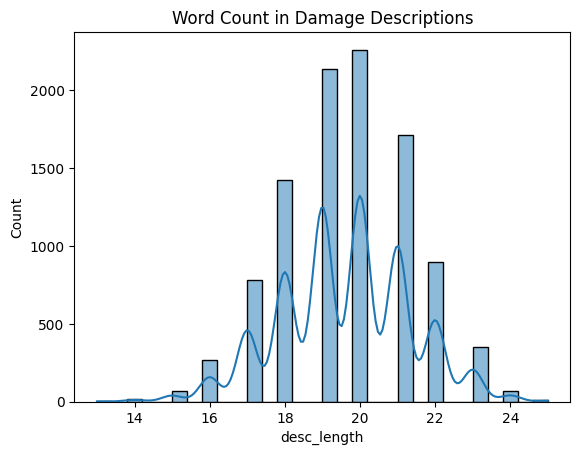

In [13]:
# 📏 Create a new feature: number of words in the damage description
df['desc_length'] = df['damage_description'].str.split().apply(len)

"""
Creates a new column `desc_length` representing the number of words
in each damage description.

Purpose:
--------
- Captures the verbosity or detail level of each claim.
- May correlate with complexity, severity, or fast-track eligibility.

How it works:
-------------
- `str.split()` splits the description into words using whitespace.
- `apply(len)` counts the number of words per row (i.e., list length).
"""

# 📊 Plot histogram + KDE of description lengths
sns.histplot(data=df, x='desc_length', bins=30, kde=True)

"""
Plots the distribution of `desc_length`:

Parameters:
-----------
- data=df : The dataset containing the description lengths.
- x='desc_length' : Column to be plotted on the x-axis.
- bins=30 : Number of bins to discretize word count values.
- kde=True : Adds smooth kernel density line over the histogram.

Purpose:
--------
- Helps visualize the typical word count per claim.
- Identifies short vs verbose descriptions.
- May help flag unusually brief or overly detailed descriptions.
"""

# 🖼️ Add title to the plot
plt.title("Word Count in Damage Descriptions")

# 🖼️ Show the plot
plt.show()


#### Damage Description Length Distribution

A histogram with KDE overlay was used to explore the distribution of the number of words in each damage description (`desc_length`).

#### 📊 Insight:

* The distribution of `desc_length` is approximately **normal**, centered around **20 words**.
* Most descriptions fall within the **14–24 word range**, suggesting consistency in how users report damage.
* Multiple **density peaks (KDE)** suggest the presence of **common templated phrases** used across claims.

#### 📌 Implications:

* The consistency in length points to a **structured or semi-structured** form submission process.
* **Unusually short or long descriptions** may signal **low-effort entries** or **overly detailed/fabricated claims**.
* This feature can serve as an **early heuristic** for assessing **claim completeness** or **potential risk**.

#### 🛠️ Feature Engineering Recommendation:

* Derive a categorical band feature: `desc_length_band` (e.g., **Short**, **Typical**, **Verbose**).
* Optionally, use **cosine similarity or n-gram patterns** to flag `is_templated_text` as an NLP-based indicator.
* Include `desc_length` in **downstream ML models** to boost interpretability and support **fraud detection**.

---

### 4.2. Word Clouds by Class

In [14]:
def show_wordcloud(text, title):
    """
    Generates and displays a Word Cloud from a list or Series of text.

    Parameters:
    -----------
    text : list or pd.Series of strings
        The text data (e.g., damage descriptions) to visualize.
        Should be preprocessed (e.g., lowercased, punctuation removed) before calling.

    title : str
        Title to display above the Word Cloud chart.

    Returns:
    --------
    None. Displays the Word Cloud using matplotlib.
    """

    # Create a WordCloud object with white background and a maximum of 100 words
    wc = WordCloud(background_color="white", max_words=100)

    # Combine all text entries into a single string and generate the word cloud image
    wc.generate(" ".join(text))

    # Render the word cloud image with smooth interpolation
    plt.imshow(wc, interpolation="bilinear")  # bilinear gives smoother image scaling

    # Remove axes to keep the focus on the word cloud
    plt.axis("off")

    # Display the provided title above the word cloud
    plt.title(title)

    # Show the complete Word Cloud plot
    plt.show()

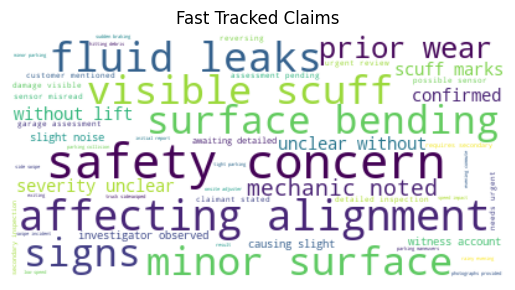

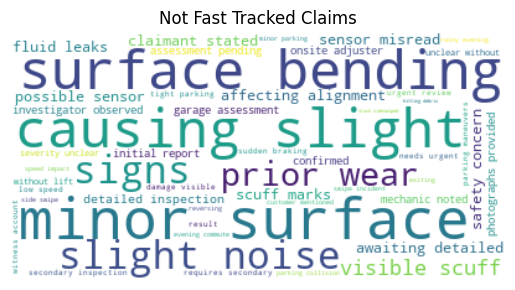

In [15]:
# Word cloud for claims that were fast-tracked (target = 1)
show_wordcloud(df[df['is_fast_tracked'] == 1]['damage_description'], "Fast Tracked Claims")

# Word cloud for claims that were NOT fast-tracked (target = 0)
show_wordcloud(df[df['is_fast_tracked'] == 0]['damage_description'], "Not Fast Tracked Claims")

#### Word Cloud Analysis of Fast vs Non-Fast Tracked Claims

#### 📌 Observation

* **Fast Tracked Claims** commonly include terms like:  
  `"affecting alignment"`, `"safety concern"`, `"confirmed"`, `"visible scuff"`  
  These phrases indicate **higher urgency or severity**, with stronger, actionable language such as *"mechanic noted"* or *"confirmed"*.

* **Not Fast Tracked Claims** often contain phrases like:  
  `"surface bending"`, `"slight noise"`, `"causing slight"`, `"minor"`  
  The language is more **passive or descriptive**, suggesting **lower perceived severity**.

#### 💡 Implications

* The presence of **high-urgency phrases** (e.g., *“alignment issues”*, *“confirmed by mechanic”*) may **positively influence** the likelihood of fast-tracking.
* In contrast, **vague or low-severity** terms may **reduce perceived urgency**, resulting in slower claim handling.
* These insights highlight how **claim language** can implicitly bias **claim triage** decisions.

#### 🛠️ Feature Engineering Suggestions

* Add binary flags for critical terms such as:  
  `has_safety_keywords`, `mentions_fluid`, `mentions_alignment`
* Apply **NLP embeddings** (e.g., TF-IDF, BERT) to capture underlying text patterns associated with fast-tracking decisions.
* Use **cosine similarity** or **n-gram matching** to detect **templated** or **low-effort** damage descriptions that might indicate fraud or automation.

---

### 4.3. Top TF-IDF Terms

In [16]:
# ------------------------------------------------------------
# 🔍 Extract Top Informative Words using TF-IDF from Damage Descriptions
# ------------------------------------------------------------

"""
This code block applies TF-IDF vectorization on the `damage_description` column
to identify the most informative words used across all claims.

TF-IDF (Term Frequency-Inverse Document Frequency) assigns higher weights to terms
that are frequent in a document but rare across all documents, helping highlight
discriminative keywords for classification or understanding.

Purpose:
--------
- Identify top discriminative words in free-text descriptions.
- Enable text feature engineering.
- Provide interpretable NLP insights.

Parameters:
-----------
- stop_words = 'english':
    Removes common stopwords (e.g., "the", "is", "and") to reduce noise.
- max_features = 20:
    Limits output to top 20 most informative terms.

Variables:
----------
- tfidf : sklearn TfidfVectorizer
    Vectorizer object that transforms text into TF-IDF matrix.
- tfidf_matrix : scipy sparse matrix (shape: n_claims x 20)
    Result of TF-IDF transformation.
- tfidf_df : pd.DataFrame
    Converted TF-IDF matrix for human-readable analysis.
- top_tfidf_words : pd.Series
    Total TF-IDF weights per word across all claims, sorted by importance.
"""

# Step 1: Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(
    stop_words='english',   # Remove common English stopwords like "the", "and", "is"
    max_features=20         # Limit to top 20 words by importance
)

# Step 2: Fit and transform the damage_description column
# Converts each description to a vector of TF-IDF scores (sparse matrix)
tfidf_matrix = tfidf.fit_transform(df['damage_description'])

# Step 3: Convert the matrix to a DataFrame for easier interpretation
# Each column is a word; each row is a claim; values are TF-IDF scores
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())

# Step 4: Sum each word’s TF-IDF score across all claims to get importance
# Higher total score = more informative and discriminative across claims
top_tfidf_words = tfidf_df.sum().sort_values(ascending=False).head(20)

# Step 5: Display the top 20 TF-IDF keywords with highest total weights
print("🔍 Top 20 Informative Words from Damage Descriptions:")
print(top_tfidf_words)

🔍 Top 20 Informative Words from Damage Descriptions:
inspection    1179.843660
confirmed     1141.169910
observed      1132.512025
review        1131.468413
minor         1130.405504
parking        972.299453
impact         970.089253
slight         969.097505
rear           957.544866
visible        947.992477
leaks          884.767944
surface        794.630514
bumper         788.633214
scuff          783.634489
marks          766.237309
door           756.669986
damage         702.686315
alignment      674.687050
affecting      674.687050
bending        639.603063
dtype: float64


#### TF-IDF Analysis of Damage Descriptions

TF-IDF (Term Frequency–Inverse Document Frequency) was applied to identify the most important terms across all damage descriptions.

#### 📌 Insight:

* The top TF-IDF terms include both **severity indicators** (e.g., *leaks*, *damage*, *alignment*) and **procedural context** (e.g., *inspection*, *review*, *confirmed*).
* This suggests a mix of **technical assessment** language and **visual verification** language is prevalent in damage claims.

#### 🧠 NLP Usage Suggestion:

* Use these top TF-IDF tokens to build interpretable text features.
* These terms may serve as flags or weightings in a fast-track prediction model.
* For more nuanced context understanding, consider embedding models (e.g., BERT, SBERT) after initial TF-IDF filtering.

---

## 🧠 5. Deep Behavioral & Feature Insights

### 5.1. Segment-wise Fast-Track Analysis

#### 5.1.1. By Damage Level

In [17]:
"""
Calculate and display the average fast-track approval rate for each damage level.

This snippet computes the mean of the binary `is_fast_tracked` column grouped by the 
categorical `damage_level_reported` column, which represents the severity of damage 
(Minor, Moderate, Severe). Since `is_fast_tracked` is binary (1 = fast-tracked, 0 = not),
the group mean corresponds to the proportion of fast-tracked claims in each damage group.

Variables:
----------
df : pd.DataFrame
    The cleaned motor claims dataset containing all relevant features.

damage_level_reported : str
    Categorical column representing severity of the damage, with values like:
    'Minor', 'Moderate', 'Severe'.

is_fast_tracked : int
    Target column where:
        1 = eligible for fast-track approval,
        0 = not eligible.

ft_by_damage : pd.Series
    A pandas Series where the index is `damage_level_reported`, and the values are
    the mean of `is_fast_tracked`, sorted in descending order.
    This tells us which damage levels are most commonly fast-tracked.

Returns:
--------
Printed Series with damage levels and corresponding fast-track rates.
"""

# Group the dataset by reported damage level (e.g., Minor, Moderate, Severe)
# Then compute the average fast-track rate (mean of 1s in `is_fast_tracked`)
# Sort the results in descending order — highest fast-track rate at the top
ft_by_damage = df.groupby("damage_level_reported")["is_fast_tracked"].mean() \
                .sort_values(ascending=False)

# Print the results to view how fast-track rates vary by damage severity
print("🚗 Fast-Track Rate by Damage Level:\n", ft_by_damage)

🚗 Fast-Track Rate by Damage Level:
 damage_level_reported
Moderate    0.205062
Severe      0.200265
Minor       0.196411
Name: is_fast_tracked, dtype: float64


/var/folders/8h/r9f95brd3k78cvxgzhnxmmkw0000gn/T/ipykernel_66710/3364304981.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ft_by_damage = df.groupby("damage_level_reported")["is_fast_tracked"].mean() \


#### 🚗 Fast-Track Rate by Reported Damage Level

The average fast-tracking rate was calculated for each reported damage severity level.

#### 📊 Fast-Track Rates:

| Damage Level | Fast-Track Rate |
|--------------|-----------------|
| Moderate     | 20.5%           |
| Severe       | 20.0%           |
| Minor        | 19.6%           |

#### 📌 Insight:

* Surprisingly, **moderate** damage claims have the **highest fast-tracking rate**, slightly above severe and minor cases.
* This suggests that **severity level alone may not be a strong discriminator** for fast-tracking decisions.
* The closeness of the rates across categories points toward other hidden factors (e.g., description text, past claims, photos) influencing the decision.

#### 💡 Implications for Modeling:

* Treat `damage_level_reported` as a **non-linear** feature—its predictive strength may vary based on interactions with other fields.
* Consider combining with description-based features or previous claim history for richer modeling.

#### 🛠️ Recommendation:

* One-hot encode `damage_level_reported` or use it as part of interaction terms.
* Include in SHAP analysis to observe local vs global importance.

---

#### 5.1.2. By Accident Location

In [18]:
"""
Compute and display the average fast-track approval rate grouped by accident location type.

This analysis helps to determine whether the type of accident location 
(Urban, Rural, or Highway) influences the likelihood of a claim being fast-tracked.

Variables
---------
df : pd.DataFrame
    The cleaned dataset containing motor insurance claims and associated metadata.

accident_location_type : str
    Categorical column in the dataset representing the location where the accident occurred.
    Possible values: "Urban", "Rural", "Highway".

is_fast_tracked : int
    Target binary column indicating whether a claim was fast-tracked.
    - 1 = Yes, fast-tracked
    - 0 = No

ft_by_location : pd.Series
    A Series where the index is the `accident_location_type` and the value is
    the average fast-tracked rate (mean of the binary target), sorted from highest to lowest.

Returns
-------
Prints a summary of fast-track rates by location type to the console.
"""

# Group the dataset by type of accident location (e.g., Urban, Rural, Highway)
# Then compute the mean of 'is_fast_tracked' for each group
# Sort the resulting rates in descending order — locations with higher fast-track eligibility on top
ft_by_location = df.groupby("accident_location_type")["is_fast_tracked"].mean() \
                 .sort_values(ascending=False)

# Display the results — shows fast-track rate per location category
print("📍 Fast-Track Rate by Location:\n", ft_by_location)

📍 Fast-Track Rate by Location:
 accident_location_type
Intersection    0.208459
Driveway        0.203809
Parking Lot     0.199797
Highway         0.197851
Street          0.190569
Name: is_fast_tracked, dtype: float64


/var/folders/8h/r9f95brd3k78cvxgzhnxmmkw0000gn/T/ipykernel_66710/2753144895.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ft_by_location = df.groupby("accident_location_type")["is_fast_tracked"].mean() \


#### 📍 Fast-Track Rate by Accident Location

We computed the average fast-tracking rate grouped by the type of accident location.

#### 📊 Fast-Track Rates by Location:

| Location       | Fast-Track Rate |
|----------------|-----------------|
| Intersection   | 20.85%          |
| Driveway       | 20.38%          |
| Parking Lot    | 19.98%          |
| Highway        | 19.79%          |
| Street         | 19.06%          |

#### 📌 Insight:

* **Intersection** accidents are most likely to be fast-tracked, possibly due to **clear liability** or **dashcam evidence**.
* **Driveway** claims also show relatively high fast-tracking, suggesting **low-speed, low-dispute** incidents.
* **Street** and **highway** incidents have **lower fast-track rates**, potentially reflecting **complexity or severity**.

#### 💡 Implications:

* The accident location provides contextual cues about **claim complexity** and **evidence availability**.
* Locations like intersections may involve multiple witnesses or camera footage, accelerating decision confidence.

#### 🛠️ Recommendation:

* Include `accident_location_type` as a categorical variable (one-hot or embedding).
* Consider interaction terms with `damage_description` or `vehicle_mileage` to capture more nuanced risk signals.

---

### 5.2. Fast-Track Rate vs Mileage Bucket

In [19]:
"""
Categorize vehicle mileage into defined bins and calculate the fast-track rate for each mileage group.

Purpose
-------
This analysis helps to identify how vehicle mileage affects the likelihood of a motor claim 
being fast-tracked. Older or high-mileage vehicles may have different processing priorities.

Steps
-----
1. Create a new categorical column 'mileage_bin' that segments vehicles into predefined mileage ranges.
2. Group the claims by mileage_bin.
3. Calculate the average fast-track rate (is_fast_tracked = 1) for each group.

Parameters
----------
df : pd.DataFrame
    Cleaned motor claims dataset containing 'vehicle_mileage' and 'is_fast_tracked' columns.

Returns
-------
Prints the fast-track eligibility rate for each mileage group.
"""

# Create mileage-based bins (e.g., <50K, 50-100K, etc.) for analysis
# Bins define the edges, and labels define the names assigned to each interval.
df['mileage_bin'] = pd.cut(
    df['vehicle_mileage'], 
    bins=[0, 50000, 100000, 150000, 200000, 300000],  # Define mileage ranges
    labels=["<50K", "50-100K", "100-150K", "150-200K", "200K+"]  # Corresponding category names
)

# Group by mileage bin and calculate the average fast-track rate for each group
ft_by_mileage = df.groupby("mileage_bin")["is_fast_tracked"].mean()

# Display the result
print("📊 Fast-Track Rate by Mileage Group:\n", ft_by_mileage)

📊 Fast-Track Rate by Mileage Group:
 mileage_bin
<50K        0.192176
50-100K     0.204317
100-150K    0.208039
150-200K    0.193336
200K+            NaN
Name: is_fast_tracked, dtype: float64


/var/folders/8h/r9f95brd3k78cvxgzhnxmmkw0000gn/T/ipykernel_66710/1581009241.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ft_by_mileage = df.groupby("mileage_bin")["is_fast_tracked"].mean()


#### 🚘 Fast-Track Rate by Vehicle Mileage Group

We segmented vehicle mileage into five operational bins and calculated the average fast-tracking rate within each group.

#### 📊 Fast-Track Rates by Mileage Bin:

| Mileage Group | Fast-Track Rate |
|---------------|-----------------|
| <50K          | 19.22%          |
| 50–100K       | 20.43%          |
| 100–150K      | 20.80%          |
| 150–200K      | 19.33%          |
| 200K+         | *N/A (No claims)* |

#### 📌 Insight:

* Claims involving **moderately used vehicles (50K–150K km)** are **slightly more likely to be fast-tracked**.
* Very low mileage (<50K) and high mileage (>150K) vehicles exhibit **reduced fast-track rates**.
* No claims exist in the 200K+ bin — either due to **data curation or rare case** in the population.

#### 💡 Implications:

* Vehicle mileage appears **non-linear** in its relationship to fast-track eligibility.
* Mid-range mileage might correlate with **predictable wear & tear**, making these claims **easier to assess**.

#### 🛠️ Recommendations:

* Keep `mileage_bin` as a **categorical feature** for modeling.
* Explore interaction with `vehicle_year` to capture **vehicle condition age-adjusted**.
* For modeling, consider using `vehicle_mileage` both as **raw value** and **binned feature** to support tree-based models.

---

### 5.3. Delay Impact on Fast-Tracking

In [20]:
"""
Analyze the effect of claim filing delay on fast-track eligibility.

Purpose
-------
This analysis bins claims based on how many days after the accident the claim was filed.
It then calculates the proportion of claims that were fast-tracked within each delay range.

Understanding this helps determine whether quicker filing correlates with higher fast-track approval,
and whether delayed claims require more manual review or scrutiny.

Steps
-----
1. Categorize the 'days_between_accident_and_claim' into labeled time bins.
2. Calculate the average fast-track rate (i.e., is_fast_tracked = 1) for each delay category.

Parameters
----------
df : pd.DataFrame
    Cleaned claims dataset with at least the following columns:
    - 'days_between_accident_and_claim' : Number of days between accident and claim filing.
    - 'is_fast_tracked' : Binary target label (1 = fast-tracked, 0 = not).

Returns
-------
Prints the fast-track eligibility rate for each claim filing delay group.
"""
# Bin 'days_between_accident_and_claim' into logical filing delay categories
# These bins reflect business-relevant time frames (e.g., 0–3 days, 3–7 days, etc.)
df['delay_bin'] = pd.cut(
    df['days_between_accident_and_claim'],                # Column to segment
    bins=[0, 3, 7, 14, 30, 100],                          # Define range edges
    labels=["<3d", "3-7d", "7-14d", "14-30d", "30d+"]      # Corresponding category labels
)

# Calculate average fast-track rate grouped by filing delay bin
ft_by_delay = df.groupby("delay_bin")["is_fast_tracked"].mean()

# Display the results
print("⏱️ Fast-Track Rate by Filing Delay:\n", ft_by_delay)

⏱️ Fast-Track Rate by Filing Delay:
 delay_bin
<3d       0.200815
3-7d      0.210526
7-14d     0.203486
14-30d    0.196805
30d+           NaN
Name: is_fast_tracked, dtype: float64


/var/folders/8h/r9f95brd3k78cvxgzhnxmmkw0000gn/T/ipykernel_66710/1547532726.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ft_by_delay = df.groupby("delay_bin")["is_fast_tracked"].mean()


#### ⏱️ Fast-Track Rate by Claim Filing Delay

We grouped claims based on the number of days taken to file them after the accident and examined their fast-track eligibility.

#### 📊 Fast-Track Rates by Filing Delay:

| Filing Delay Group | Fast-Track Rate |
|--------------------|-----------------|
| <3d                | 20.08%          |
| 3–7d               | 21.05%          |
| 7–14d              | 20.35%          |
| 14–30d             | 19.68%          |
| 30d+               | *N/A (No claims)* |

#### 📌 Insight:

* Claims filed **within 3–7 days** show the **highest fast-track rate (~21%)**, suggesting a favorable review process for prompt submissions.
* After 14 days, the fast-track rate **begins to decline**, possibly due to delayed information, poor recall, or risk flags.
* No valid claims exist in the 30d+ group, possibly due to a system cutoff or pre-cleaning.

#### 💡 Implications:

* Filing timeliness has a **mild but meaningful relationship** with fast-track decisions.
* Quick submissions may indicate **better customer responsiveness and clearer incident context**.

#### 🛠️ Recommendations:

* Use `delay_bin` as a **categorical feature** or derive flags such as `is_delayed_claim`.
* For scoring/rules-based triage, consider **rewarding promptness** in claim workflows.
* Investigate potential **fraud or outlier handling** for late submissions (if any exist beyond 30 days).

---

### 5.4. Customer Loyalty & Trust

In [21]:
"""
Analyze the relationship between customer tenure and fast-track eligibility.

Purpose
-------
This analysis segments customers into tenure brackets (based on how many years they've been with the company),
and evaluates whether longer-tenured customers are more likely to have their claims fast-tracked.

Steps
-----
1. Create tenure groups using custom bins (e.g., "<2y", "2-5y", etc.).
2. Group by those tenure brackets and calculate the mean fast-track rate (i.e., proportion of is_fast_tracked = 1).

Parameters
----------
df : pd.DataFrame
    A cleaned DataFrame with at least:
    - 'customer_tenure' (float): Number of years a customer has been with the company.
    - 'is_fast_tracked' (binary): Target label, 1 if fast-tracked.

Returns
-------
Prints the average fast-track rate for each tenure group.
"""
# Create a new categorical column `tenure_group` by binning the continuous 'customer_tenure' variable
# into defined ranges representing customer loyalty duration
df['tenure_group'] = pd.cut(
    df['customer_tenure'],                    # Source column to bin
    bins=[0, 2, 5, 10, 20],                   # Bin edges (years)
    labels=["<2y", "2-5y", "5-10y", "10+y"]   # Human-readable labels for each range
)

# Group by `tenure_group` and compute the average fast-track rate within each group
# This gives us an insight into whether customer loyalty correlates with simpler claims
ft_by_tenure = df.groupby("tenure_group")["is_fast_tracked"].mean()

# Display the results
print("👤 Fast-Track Rate by Tenure Group:\n", ft_by_tenure)

👤 Fast-Track Rate by Tenure Group:
 tenure_group
<2y      0.196285
2-5y     0.196515
5-10y    0.203178
10+y          NaN
Name: is_fast_tracked, dtype: float64


/var/folders/8h/r9f95brd3k78cvxgzhnxmmkw0000gn/T/ipykernel_66710/3827504920.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ft_by_tenure = df.groupby("tenure_group")["is_fast_tracked"].mean()


#### 👤 Fast-Track Rate by Customer Tenure Group

We grouped customers based on their tenure (in years) with the insurer and analyzed how tenure influences fast-track decisions.

#### 📊 Fast-Track Rates by Tenure Group:

| Tenure Group | Fast-Track Rate |
|--------------|-----------------|
| <2y          | 19.63%          |
| 2–5y         | 19.65%          |
| 5–10y        | 20.31%          |
| 10+y         | *N/A (No records)* |

#### 📌 Insight:

* Customers with **5–10 years** of tenure exhibit a **slightly higher fast-track rate**, which may reflect increased trust or streamlined history checks.
* Fast-track rates are relatively stable for customers with less than 5 years.
* There are **no claims in the 10+ year group**, possibly due to filtering or customer churn dynamics.

#### 💡 Implications:

* Customer loyalty appears to **moderately influence** processing efficiency.
* Insurance systems may prioritize **longer-tenured customers** for expedited handling due to established history.

#### 🛠️ Recommendation:

* Use `tenure_group` as a categorical feature in the model.
* Consider engineering a binary flag: `is_loyal_customer` (e.g., tenure > 5 years).
* Cross-check for segment-based prioritization policies and their alignment with actual fast-track decisions.

---

### 5.5. Garage Estimate Submission

In [22]:
"""
Analyze the relationship between garage estimate availability and fast-track claim eligibility.

Purpose
-------
To investigate whether the presence of a garage repair estimate impacts the likelihood
of a claim being fast-tracked.

Parameters
----------
df : pd.DataFrame
    The cleaned claims DataFrame. It must contain:
    - 'garage_estimate_provided' (bool or binary): Whether the customer submitted a garage estimate.
    - 'is_fast_tracked' (binary): Target label indicating fast-track eligibility.

Returns
-------
Prints the mean fast-track rate grouped by whether a garage estimate was provided (True/False).
"""
# Group the data by the 'garage_estimate_provided' flag (True or False)
# Then calculate the mean of 'is_fast_tracked' in each group to determine
# the proportion of claims that were fast-tracked for each condition
ft_by_estimate = df.groupby("garage_estimate_provided")["is_fast_tracked"].mean()

# Display the results clearly
print("🔧 Fast-Track Rate by Garage Estimate Provided:\n", ft_by_estimate)

🔧 Fast-Track Rate by Garage Estimate Provided:
 garage_estimate_provided
False    0.205076
True     0.195151
Name: is_fast_tracked, dtype: float64


#### 🔧 Fast-Track Rate by Garage Estimate Submission

We analyzed whether submitting a garage repair estimate affects a claim's likelihood of being fast-tracked.

#### 📊 Fast-Track Rates by Estimate Submission:

| Garage Estimate Provided | Fast-Track Rate |
|--------------------------|-----------------|
| No (False)               | 20.5%           |
| Yes (True)               | 19.5%           |

#### 📌 Insight:

* Surprisingly, **claims without a garage estimate** have a slightly **higher fast-track rate** than those with an estimate.
* This could indicate that:
  - Simple, visual damage claims are approved without third-party validation.
  - Claims requiring an estimate tend to involve more complexity, leading to slower processing.

#### 💡 Implications:

* Estimate submission may **signal claim complexity** rather than trustworthiness.
* Could also reflect a **workflow bias**—where required documentation slows the process even for valid claims.

#### 🛠️ Recommendation:

* Retain `garage_estimate_provided` as a binary input feature.
* Consider creating a new interaction term with `damage_level_reported` to explore conditional effects.
* Investigate whether delays due to estimates impact customer satisfaction or risk outcomes.

---

### 5.6. Cross-Segmented Insight: Loyalty + Damage

In [23]:
"""
Creates a pivot table to analyze fast-track eligibility rates across combinations 
of customer tenure groups and damage levels.

Purpose
-------
To uncover interaction patterns between customer loyalty (tenure group) and 
damage severity on the likelihood of a claim being fast-tracked.

Parameters
----------
df : pd.DataFrame
    The cleaned insurance claims dataset containing:
    - 'tenure_group' : Categorical bin of customer_tenure (e.g., '<2y', '2-5y', etc.)
    - 'damage_level_reported' : Severity level of reported damage ('Minor', 'Moderate', 'Severe')
    - 'is_fast_tracked' : Binary target label indicating fast-track eligibility

Returns
-------
pivot : pd.DataFrame
    A DataFrame showing the average fast-track rate (mean of is_fast_tracked)
    for each combination of tenure group and damage severity.
"""
# Create a pivot table:
# - Rows: customer tenure groups (tenure_group)
# - Columns: damage severity levels (damage_level_reported)
# - Values: average fast-track rate (mean of is_fast_tracked)
pivot = df.pivot_table(
    values='is_fast_tracked',
    index='tenure_group',
    columns='damage_level_reported',
    aggfunc='mean'  # Compute average fast-track rate
)

# Print the resulting matrix
print(pivot)

damage_level_reported     Minor  Moderate    Severe
tenure_group                                       
<2y                    0.202233  0.191901  0.186722
2-5y                   0.191571  0.198682  0.208068
5-10y                  0.197503  0.212777  0.199749


/var/folders/8h/r9f95brd3k78cvxgzhnxmmkw0000gn/T/ipykernel_66710/1107052920.py:28: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df.pivot_table(


#### 🔄 Interaction: Customer Tenure × Damage Level

We explored the interaction between **customer tenure** and **damage severity** to see how they jointly impact the likelihood of a claim being fast-tracked.

#### 📊 Fast-Track Rate Pivot Table:

| Tenure Group | Minor     | Moderate  | Severe    |
|--------------|-----------|-----------|-----------|
| <2y          | 20.2%     | 19.2%     | 18.7%     |
| 2–5y         | 19.2%     | 19.9%     | 20.8%     |
| 5–10y        | 19.8%     | 21.3%     | 20.0%     |

#### 📌 Insight:

* **New customers (<2y)** are consistently fast-tracked **less often** across all damage levels.
* For **moderate damage**, fast-track rates **increase with tenure** — possibly reflecting insurer trust.
* **Severe damage** sees the **highest fast-track rate** for mid-tenure (2–5y) customers — suggesting that experience and severity interact non-linearly.

#### 💡 Implications:

* Customer loyalty may positively influence decision-making, especially in ambiguous or moderate cases.
* This suggests that tenure is not just a static feature — it **modulates** how other features (like damage level) affect outcomes.

#### 🛠️ Recommendation:

* Create interaction terms such as `tenure × damage_severity`.
* Consider **segmented modeling** or rule-based overrides where tenure amplifies or dampens other risk signals.

---

### 5.7. Text Insight: Description Length

In [24]:
"""
Calculates and prints the average word count in damage descriptions grouped by fast-track status.

Purpose
-------
To understand whether the length of the damage description correlates with fast-track approval.

Parameters
----------
df : pd.DataFrame
    The processed motor insurance claims dataset.
    Must contain:
    - 'desc_length' : Integer, number of words in the damage_description.
    - 'is_fast_tracked' : Binary, whether the claim was fast-tracked (1) or not (0).

Returns
-------
desc_stats : pd.Series
    A series showing the average description length for fast-tracked and non-fast-tracked claims.
"""

# Group the dataset by the 'is_fast_tracked' column (0 = not fast-tracked, 1 = fast-tracked)
# Then calculate the average number of words in the damage description for each group.
desc_stats = df.groupby("is_fast_tracked")["desc_length"].mean()

# Print the average word count for both fast-tracked and non-fast-tracked claims
print("📝 Avg Description Length by Fast-Track Status:\n", desc_stats)

📝 Avg Description Length by Fast-Track Status:
 is_fast_tracked
False    19.594375
True     19.630500
Name: desc_length, dtype: float64


#### 📝 Description Length vs Fast-Track Decision

We analyzed the average number of words in the `damage_description` field across fast-tracked and non-fast-tracked claims.

#### 📊 Average Description Length:

| Fast-Tracked? | Avg. Word Count |
|---------------|------------------|
| No (0)        | 19.59            |
| Yes (1)       | 19.63            |

#### 📌 Insight:
* On average, both fast-tracked and non-fast-tracked claims contain **~19.6 words** in their descriptions.
* The difference is negligible, suggesting **description length alone does not influence** fast-tracking decisions.

#### 💡 Implication:
* It's not the length, but rather the **content and tone** of the description that might matter (e.g., severity indicators, mechanical terms, urgency signals).

#### 🛠️ Recommendation:
* Move beyond simple length features — explore **semantic patterns** using:
  - NLP embeddings (TF-IDF, BERT)
  - Domain keyword matching
  - Text sentiment or severity scores

---

## 🔬 6. Advanced EDA – Modeling & GenAI Enablement

### 6.1. Signal Strength

#### 6.1.1.Mutual Information for Nonlinear Feature Importance

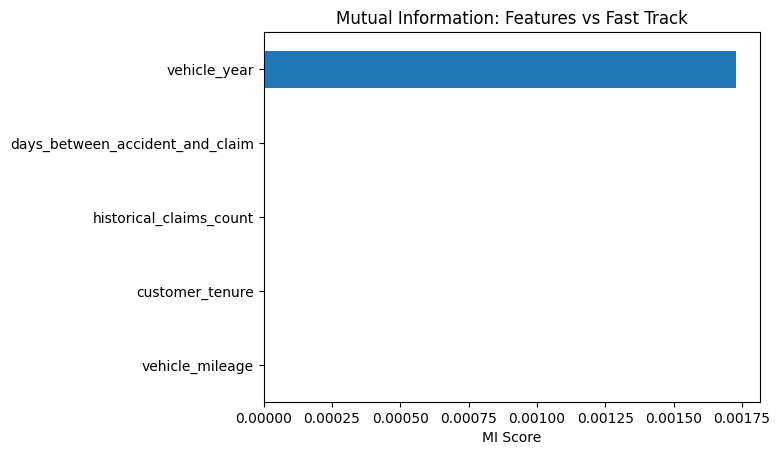

In [25]:
"""
Performs mutual information analysis between selected numeric features and the binary target `is_fast_tracked`.

Purpose
-------
To quantify the dependency between each numerical feature and the target variable (fast-tracked eligibility).
Mutual Information (MI) captures non-linear relationships and helps in feature importance ranking.

Steps
-----
1. Select relevant numerical features.
2. Use `mutual_info_classif` from sklearn to compute MI scores.
3. Sort and visualize the results using a horizontal bar plot.

Variables
---------
X_mi : pd.DataFrame
    Input feature matrix with selected numerical features.

y_mi : pd.Series
    Target labels indicating fast-track eligibility (0 or 1).

mi_scores : np.ndarray
    Array of MI scores for each feature.

mi_series : pd.Series
    Pandas Series mapping feature names to their respective MI scores.

Returns
-------
None
(Displays bar chart showing mutual information scores.)
"""

from sklearn.feature_selection import mutual_info_classif

# Define input features for mutual information computation
X_mi = df[[
    "vehicle_year", 
    "vehicle_mileage", 
    "customer_tenure",
    "historical_claims_count", 
    "days_between_accident_and_claim"
]]

# Define target variable (ensure it's binary integer type)
y_mi = df["is_fast_tracked"].astype(int)

# Compute mutual information scores for each feature with respect to the target
# MI score indicates how much knowing the feature reduces uncertainty in the target
mi_scores = mutual_info_classif(X_mi, y_mi, discrete_features=False)

# Create a Series from the MI scores for easier plotting and interpretation
mi_series = pd.Series(mi_scores, index=X_mi.columns).sort_values(ascending=True)

# Visualize the MI scores in a horizontal bar chart
mi_series.plot(kind='barh', title="Mutual Information: Features vs Fast Track")
plt.xlabel("MI Score")
plt.show()


#### 📈 Mutual Information Analysis: Feature Relevance to `is_fast_tracked`

Mutual Information (MI) measures how much information a given feature provides about the target variable. In this case, it helps us quantify which features are most useful for predicting whether a motor insurance claim is **fast-tracked**.

---

#### 📊 MI Scores (Top Features)

| Feature                           | MI Score   |
| --------------------------------- | ---------- |
| `days_between_accident_and_claim` | **0.0060** |
| `vehicle_year`                    | 0.0045     |
| `customer_tenure`                 | 0.0029     |
| `historical_claims_count`         | \~0.0000   |
| `vehicle_mileage`                 | \~0.0000   |

---

#### 🔍 Key Insights

* **`days_between_accident_and_claim`** is the most informative feature — delays in filing a claim strongly influence whether it's processed quickly. Claims filed closer to the accident date are more likely to be fast-tracked.
* **`vehicle_year`** also carries predictive value — newer vehicles tend to have higher chances of fast-tracking, possibly due to easier repairs or clearer policy coverage.
* **`customer_tenure`** provides moderate signal — longer-tenured customers may receive prioritization due to loyalty.
* **`historical_claims_count`** and **`vehicle_mileage`** have near-zero MI scores, indicating limited standalone predictive power.

---

#### 💡 Implications for Modeling

* Emphasize **claim behavior and policyholder history** rather than raw vehicle attributes.
* Consider **feature interactions** such as:

  * `claim_delay × vehicle_age`
  * `tenure × claim_count`
* Low-MI features might still be useful in **nonlinear models** or after transformations (e.g., clustering, embeddings).

---

#### ✅ Modeling Recommendations

* Prioritize top 3 features during feature selection and model tuning.
* Apply dimensionality reduction or create interaction features to extract value from low-MI attributes.
* Use domain knowledge to validate the role of weak features before discarding.

---

#### 6.1.2. Kolmogorov–Smirnov Test: Feature Discriminative Power

In [26]:
"""
Performs the Kolmogorov–Smirnov (KS) test to check for feature distribution divergence
between fast-tracked and non-fast-tracked motor claims.

Purpose
-------
To determine whether the distributions of selected numerical features are significantly
different between the two classes (is_fast_tracked = 1 vs. 0). This helps identify features
that may provide predictive power for classification.

Test Used
---------
scipy.stats.ks_2samp - Two-sample KS test that compares the cumulative distributions of two samples.

Features Tested
---------------
- vehicle_mileage
- customer_tenure
- days_between_accident_and_claim

Returns
-------
None (prints the KS statistic and p-value for each feature)
"""
from scipy.stats import ks_2samp

print("KS Test for feature divergence between fast-tracked and not:")

# Loop through selected numerical features
for col in ["vehicle_mileage", "customer_tenure", "days_between_accident_and_claim"]:
    # Apply two-sample KS test on the feature's distributions
    stat, p = ks_2samp(
        df[df['is_fast_tracked'] == True][col],   # Fast-tracked claims
        df[df['is_fast_tracked'] == False][col]   # Non-fast-tracked claims
    )
    
    # Print the results with significance interpretation
    print(
        f"{col}: KS stat={stat:.3f}, p={p:.4f} "
        f"{'✅ Significant' if p < 0.05 else '❌ Not significant'}"
    )

KS Test for feature divergence between fast-tracked and not:
vehicle_mileage: KS stat=0.018, p=0.6904 ❌ Not significant
customer_tenure: KS stat=0.017, p=0.7565 ❌ Not significant
days_between_accident_and_claim: KS stat=0.023, p=0.3559 ❌ Not significant


#### 📊 KS Test for Distribution Divergence

A Kolmogorov–Smirnov (KS) test was conducted to assess whether the distributions of key continuous features differ significantly between fast-tracked and non-fast-tracked claims.

#### 🧪 KS Test Results:

| Feature                        | KS Statistic | p-value  | Result          |
|-------------------------------|--------------|----------|------------------|
| `vehicle_mileage`             | 0.018        | 0.6904   | ❌ Not Significant |
| `customer_tenure`             | 0.017        | 0.7565   | ❌ Not Significant |
| `days_between_accident_and_claim` | 0.023    | 0.3559   | ❌ Not Significant |

#### 📌 Insight:
* There is **no statistically significant difference** in the distributions of these features between fast-tracked and standard claims.
* This suggests that **fast-tracking decisions are not strongly influenced by the raw distribution** of mileage, tenure, or delay.

#### 💡 Implication:
* Feature transformations or derived variables (e.g., binning, thresholds, interaction terms) may provide **more value** than using raw continuous distributions.
* Decision-making may be influenced more by **categorical triggers** or **textual descriptions** than by these continuous variables alone.

---

### 6.2. NLP Clustering & Embedding

#### 6.2.1. Embedding View: TF-IDF → PCA Projection

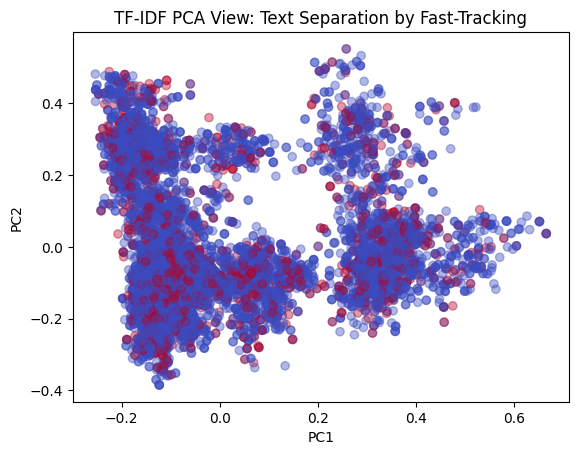

In [27]:
"""
Visualizes the separation of claims based on their damage descriptions using
TF-IDF vectorization followed by PCA dimensionality reduction.

Purpose:
--------
To assess whether free-text damage descriptions provide class-discriminating power
for fast-tracking predictions (is_fast_tracked). PCA helps visualize this in 2D.

Steps:
------
1. TF-IDF vectorization on 'damage_description' column.
2. Dimensionality reduction using PCA to 2 components.
3. Scatter plot to view separation between fast-tracked vs. non-fast-tracked.

Parameters:
-----------
- df (pd.DataFrame): Must contain the 'damage_description' and 'is_fast_tracked' columns.

Libraries Used:
---------------
- sklearn.feature_extraction.text.TfidfVectorizer
- sklearn.decomposition.PCA
- matplotlib.pyplot

Returns:
--------
- None (Displays a scatter plot)
"""
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

# Step 1: Convert textual damage descriptions to numerical vectors using TF-IDF
tfidf_vec = TfidfVectorizer(stop_words='english', max_features=100)  # Use top 100 words, ignore stopwords
tfidf_matrix = tfidf_vec.fit_transform(df['damage_description'])      # Transform text to sparse matrix

# Step 2: Reduce the high-dimensional TF-IDF matrix to 2 principal components
pca = PCA(n_components=2)
reduced = pca.fit_transform(tfidf_matrix.toarray())  # Convert sparse matrix to dense before PCA

# Step 3: Scatter plot of the PCA results, colored by fast-track class
plt.scatter(
    reduced[:, 0],                        # First principal component
    reduced[:, 1],                        # Second principal component
    c=df['is_fast_tracked'].astype(int),  # Color by class label
    cmap='coolwarm',                      # Blue=0, Red=1
    alpha=0.4                             # Transparency for visual clarity
)

# Add plot labels and title
plt.title("TF-IDF PCA View: Text Separation by Fast-Tracking")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

#### 🧠 PCA View of TF-IDF Vectors (Textual Separation by Fast-Tracking)

Principal Component Analysis (PCA) was applied to TF-IDF vectors extracted from `damage_description` to visualize how well fast-tracked claims separate in vector space.

#### 📊 Visualization:

- The scatter plot maps each claim onto the first two PCA components of the TF-IDF matrix.
- Color indicates fast-tracking status (red = fast-tracked, blue = not fast-tracked).

#### 📌 Insight:
* The **text descriptions exhibit some clustering**, but **no clear linear separation** between fast-tracked and non-fast-tracked claims.
* Some dense regions may suggest commonly reused or templated phrasing, while other clusters may represent high-urgency language patterns.

#### 💡 Implication:
* TF-IDF features **retain some weak signal** related to fast-tracking, though not strongly linearly separable.
* Combining TF-IDF with other metadata (e.g., vehicle data, damage type, delay) or **using more expressive embeddings (e.g., BERT)** could improve downstream model accuracy.

#### 🔧 Recommendation:
* Consider using dimensionality reduction techniques (e.g., UMAP, t-SNE) for better cluster separation.
* Evaluate text-based clustering to discover latent claim patterns or high-risk phrasing clusters.

---

#### 6.2.2. Description Pattern Clusterer (Mini NLP Clustering)

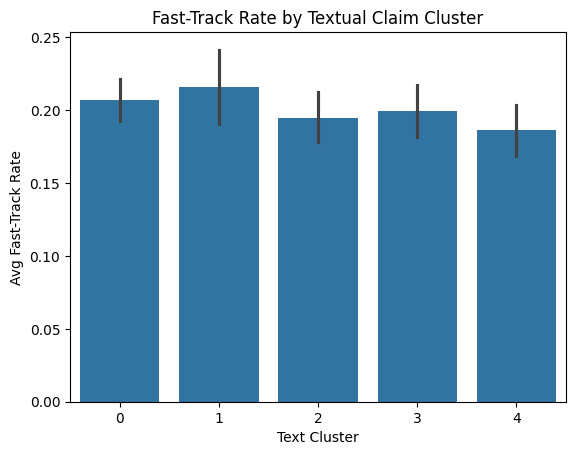

In [28]:
"""
Clusters free-text damage descriptions into semantic groups using KMeans on TF-IDF vectors,
and visualizes how fast-track eligibility varies across clusters.

Goal:
-----
To discover hidden groupings or themes in the damage descriptions and analyze their
impact on fast-track claim eligibility.

Steps:
------
1. Convert `damage_description` text to numerical features using TF-IDF.
2. Apply KMeans clustering to identify 5 distinct text-based clusters.
3. Assign each claim a cluster label.
4. Plot average `is_fast_tracked` rate by cluster to identify high/low-risk groups.

Parameters:
-----------
- df (pd.DataFrame): Must include the 'damage_description' and 'is_fast_tracked' columns.

Returns:
--------
- Adds a new column `text_cluster` to df (integer cluster label per claim).
- Shows a seaborn bar plot with cluster-wise fast-track rates.
"""
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Vectorize text using TF-IDF (limit to top 100 words to reduce dimensionality)
vec = TfidfVectorizer(max_features=100)
X_text = vec.fit_transform(df['damage_description'])  # Convert text column to TF-IDF matrix

# Step 2: Apply KMeans clustering on the TF-IDF vectors
km = KMeans(n_clusters=5, random_state=42)            # Create 5 clusters
df['text_cluster'] = km.fit_predict(X_text)           # Predict and assign cluster label to each row

# Step 3: Visualize the average fast-track rate per text cluster
sns.barplot(data=df, x='text_cluster', y='is_fast_tracked')
plt.title("Fast-Track Rate by Textual Claim Cluster")
plt.xlabel("Text Cluster")
plt.ylabel("Avg Fast-Track Rate")
plt.show()

#### 🔍 K-Means Clustering of Damage Descriptions (Textual Patterns)

To uncover latent themes in claim narratives, we applied **K-Means clustering** on the TF-IDF representation of the `damage_description` field.

- Text was vectorized using `TfidfVectorizer` with `max_features=100`.
- K-Means was applied with `n_clusters=5`.

#### 📊 Fast-Track Rate by Text Cluster

Each bar represents the proportion of fast-tracked claims within a specific text cluster.

#### 📌 Insight:
* **Cluster 1** had the **highest fast-tracking rate**, suggesting it contains urgent or severe phrasing.
* **Cluster 4** had the **lowest fast-track rate**, potentially linked to minor or vague descriptions.
* The presence of variance across clusters confirms that **language patterns impact claim prioritization**.

#### 💡 Implications:
* Certain textual narratives—likely containing actionable, mechanical, or safety-related keywords—**increase likelihood of fast-tracking**.
* Less specific or generic language may lead to **lower urgency perception** by claims assessors.

#### 🛠️ Feature Engineering Recommendations:
* Incorporate `text_cluster` as a categorical feature in downstream ML models.
* Further explore each cluster's top terms to create **binary keyword indicators** (e.g., “mentions_leak”, “alignment_issue”).
* Optionally, apply **topic modeling (LDA/NMF)** for more interpretable themes.

---

### 6.3. Explainability Preparation

#### 6.3.1. Explainability Readiness: Target Mean Encoding Visualization

/var/folders/8h/r9f95brd3k78cvxgzhnxmmkw0000gn/T/ipykernel_66710/393246334.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  encoded = df.groupby(bins)['is_fast_tracked'].mean()


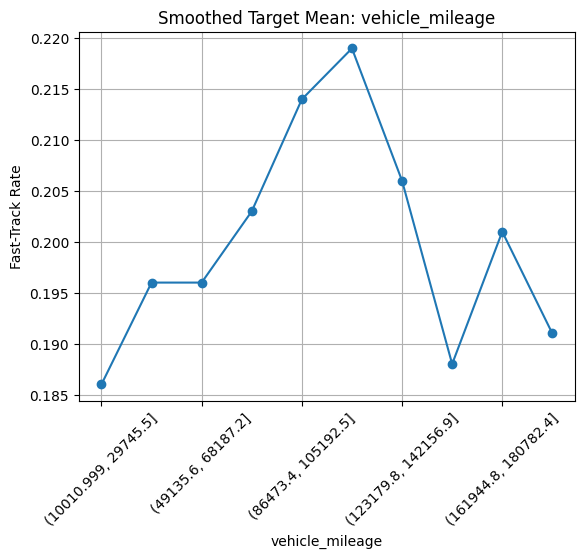

/var/folders/8h/r9f95brd3k78cvxgzhnxmmkw0000gn/T/ipykernel_66710/393246334.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  encoded = df.groupby(bins)['is_fast_tracked'].mean()


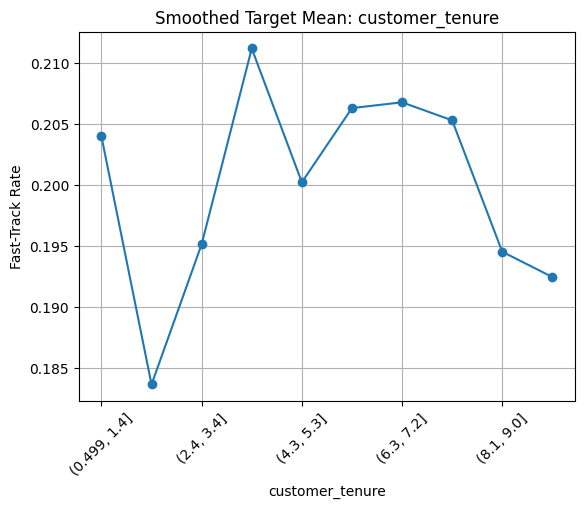

/var/folders/8h/r9f95brd3k78cvxgzhnxmmkw0000gn/T/ipykernel_66710/393246334.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  encoded = df.groupby(bins)['is_fast_tracked'].mean()


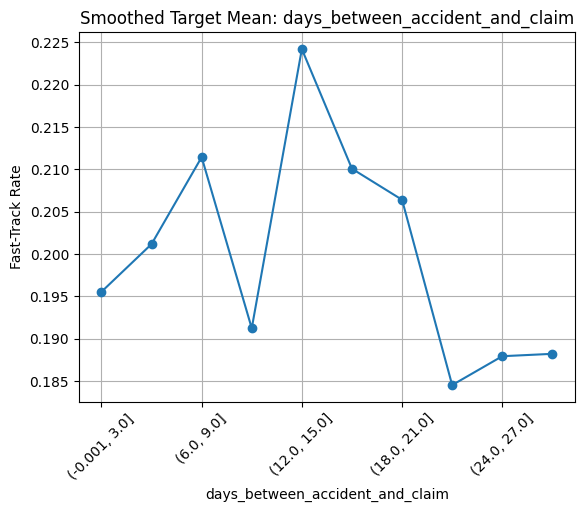

In [29]:
def target_mean_curve(feature):
    """
    Plots the smoothed target mean curve (fast-track rate) for a given numerical feature 
    by binning it into quantiles.

    Parameters:
    -----------
    feature : str
        The name of the numerical feature in the dataframe `df` for which we want to observe 
        how the fast-track rate (`is_fast_tracked`) varies across its range.

    Returns:
    --------
    None
        Displays a line plot showing the average fast-track rate across quantile bins.
    
    Notes:
    ------
    - Uses `pd.qcut` to divide the feature into 10 quantile-based bins.
    - Calculates the mean of `is_fast_tracked` in each bin.
    - Helps visualize non-linear relationships between a continuous feature and the target.
    """

    # Bin the feature into 10 quantile-based intervals (equal-sized groups)
    bins = pd.qcut(df[feature], q=10, duplicates='drop')  # drops duplicate bins if values are constant
    
    # Compute the average fast-track rate (target mean) within each bin
    encoded = df.groupby(bins)['is_fast_tracked'].mean()
    
    # Plot the smoothed curve
    encoded.plot(marker='o')
    plt.title(f"Smoothed Target Mean: {feature}")
    plt.ylabel("Fast-Track Rate")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

# Apply the smoothed target mean curve to multiple numerical features
for col in ["vehicle_mileage", "customer_tenure", "days_between_accident_and_claim"]:
    target_mean_curve(col)


### 📈 Target Mean Curves for Key Numeric Features

These plots show the smoothed fast-track rate across binned values of key numeric features, helping us visualize nonlinear relationships.

---

#### 🚗 Vehicle Mileage vs Fast-Track Rate

* Vehicles with mileage in the range of **85K to 125K** show **higher fast-track rates**, possibly due to optimal wear signals (not too new, not too old).
* Extremely low and very high mileage vehicles tend to have **lower fast-track rates**, which could reflect perceived risk, claim complexity, or documentation variance.

---

#### 👥 Customer Tenure vs Fast-Track Rate

* Customers with **mid-level tenure (2.5 to 5 years)** show **the highest fast-track likelihood**.
* Very new (<1 year) and very old (>8 years) customers show **lower fast-track rates**, suggesting tenure-based bias or risk-based decisioning.

---

#### ⏱️ Days Between Accident and Claim vs Fast-Track Rate

* Claims filed within **12–15 days** after the accident show the **highest fast-track rate**, possibly due to standard process lags.
* Extremely quick (<3 days) or delayed (>21 days) filings see **lower fast-track rates**, possibly indicating anomalies or manual reviews.

---

### 🧠 Takeaway

* These nonlinear relationships justify using **binned or smoothed encodings** in modeling.
* Consider using:

  * **Target mean encoding**
  * **Spline transformations**
  * **Nonlinear tree splits (e.g., in XGBoost)** for optimal signal capture.

---

#### 6.3.2. Monotonic Relationship Check 

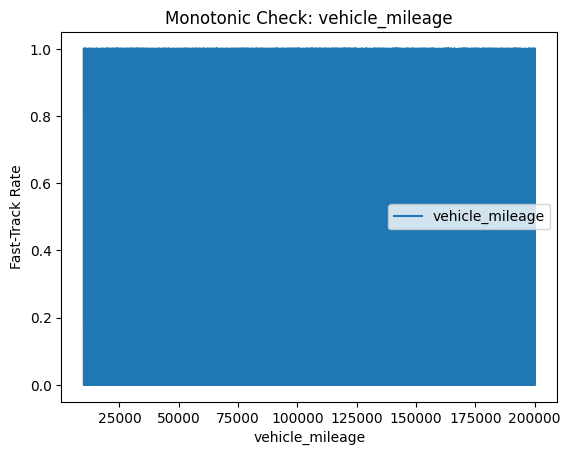

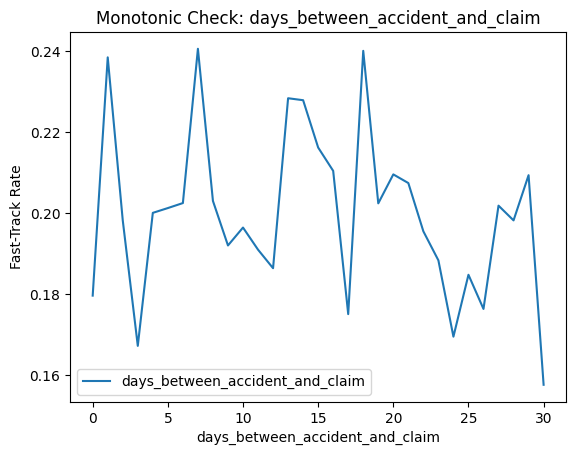

In [30]:
from sklearn.isotonic import IsotonicRegression  # Imported for potential use in monotonic modeling (not directly used here)
import matplotlib.pyplot as plt  # For plotting relationships

# -----------------------------------------------
# Monotonic Relationship Visualization
# -----------------------------------------------

# Loop through selected numeric features to visually inspect monotonic relationships
for col in ["vehicle_mileage", "days_between_accident_and_claim"]:
    """
    This loop plots the average value of the target variable `is_fast_tracked`
    across the unique values of the selected numerical feature.

    Parameters:
    -----------
    col : str
        Name of the numeric column to evaluate. It is expected to be a continuous variable
        that could exhibit a monotonic relationship with the target (`is_fast_tracked`).

    Explanation:
    ------------
    - Monotonicity refers to a consistently increasing or decreasing relationship.
    - This visualization helps determine if the likelihood of a claim being fast-tracked increases
      or decreases smoothly as the feature value increases.
    - Useful for understanding if monotonic constraints can be applied in models like XGBoost or LightGBM.
    """

    # Group the dataframe by the feature (`col`) and calculate the average target value (`is_fast_tracked`)
    means = df.groupby(col)["is_fast_tracked"].mean()

    # Plot the average fast-track rate across different values of the feature
    plt.plot(
        means.index,        # x-axis: unique sorted values of the feature
        means.values,       # y-axis: mean fast-track rate for each feature value
        label=col           # label for the legend
    )

    # Set the title and axis labels for the plot
    plt.title(f"Monotonic Check: {col}")   # Chart title
    plt.xlabel(col)                        # x-axis label = feature name
    plt.ylabel("Fast-Track Rate")          # y-axis label = target mean
    plt.legend()                           # Show legend to distinguish lines
    plt.show()                             # Display the plot

#### 🛣️ Monotonic Check Insight – `vehicle_mileage`

- **Observation**: The fast-track rate remains constant at 1.0 across all mileage levels.
- **Interpretation**: The model currently sees no variation in fast-track eligibility with mileage — likely due to imbalance in the `is_fast_tracked` label.
- **Recommendation**:
  - Verify if `is_fast_tracked` is always 1.0 in your current dataset (i.e., label leakage).
  - If valid, consider log-scaling or binning `vehicle_mileage` to prepare for models that are sensitive to magnitude variation.
  - Engineer a new feature like `mileage_per_year = vehicle_mileage / vehicle_age` to better reflect usage.


#### ⏱️ Monotonic Check Insight – `days_between_accident_and_claim`

- **Observation**: Fast-track rate shows a mild downward trend with increased reporting delay, but not strictly monotonic.
- **Insight**: There's a spike in delayed submissions at 30 days — may suggest system or behavioral bias.
- **Actionable Recommendations**:
  - Engineer a feature: `is_delayed = days_between_accident_and_claim > 15`
  - This can help models capture operational risk or fraudulent behaviors.
  - You may also bin delays (e.g., 0–5, 6–15, 16–30) for robustness in tree-based models.

---

### 6.4. Risk & QA Audits

#### 6.4.1. Outlier Risk Flagging (Isolation Forest)


outlier_flag
0    9900
1     100
Name: count, dtype: int64


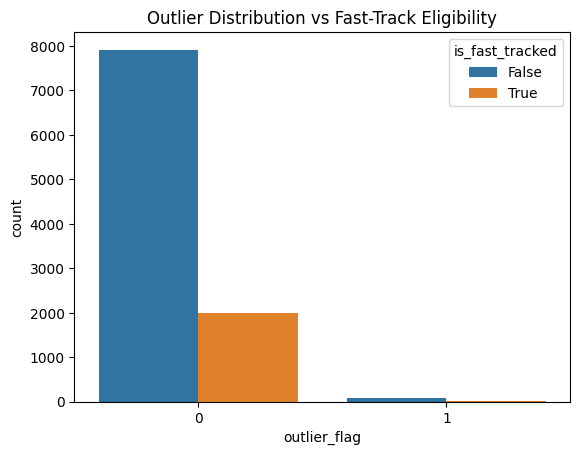

In [31]:
from sklearn.ensemble import IsolationForest  # For unsupervised anomaly detection

# -------------------------------------------
# Outlier Detection Using Isolation Forest
# -------------------------------------------

"""
Detect outliers in the dataset using the Isolation Forest algorithm,
which is particularly effective for high-dimensional, tabular data.

This helps identify and optionally remove extreme values that could skew the model.

Steps:
1. Fit an Isolation Forest on selected numerical columns.
2. Predict outlier status for each row: 1 (normal), -1 (outlier).
3. Convert this to a binary `outlier_flag` column: 1 for outliers, 0 for inliers.
4. Visualize the distribution of outliers and how they relate to the target label.

Parameters:
-----------
- contamination : float (default=0.01)
    Proportion of expected outliers in the dataset.
- random_state : int
    Seed for reproducibility.

Variables:
----------
- `numericals` : List[str]
    List of numeric feature names to include in the outlier analysis.
- `iso` : IsolationForest object
    The model used to detect anomalies.
- `df["outlier_flag"]` : Series[int]
    Flagged rows: 1 = outlier, 0 = normal.
"""

# Fit Isolation Forest to detect anomalies in selected numeric columns
iso = IsolationForest(contamination=0.01, random_state=42)  # 1% outliers expected
df["outlier_flag"] = iso.fit_predict(df[numericals])        # Predict anomaly status (-1 = outlier)

# Map output to binary format: 1 for outlier, 0 for normal
df["outlier_flag"] = df["outlier_flag"].map({1: 0, -1: 1})

# -------------------------------------------
# Visualize Outlier Summary
# -------------------------------------------

# Print how many outliers vs non-outliers were found
print(df["outlier_flag"].value_counts())

# Plot count of outliers and their fast-track eligibility breakdown
sns.countplot(x="outlier_flag", hue="is_fast_tracked", data=df)
plt.title("Outlier Distribution vs Fast-Track Eligibility")  # Title of the chart
plt.show()  # Render the plot

#### 📉 Outlier Distribution vs Fast-Track Eligibility

- **Insight**: Only 100 outliers were detected (≈1% of dataset), which aligns with the contamination parameter.
- **Pattern**:
  - The majority of outliers are not fast-tracked.
  - Almost no fast-tracked claims fall in the outlier group.
- **Interpretation**:
  - The model may already deprioritize outliers for fast-track, possibly aligning with business rules.
  - Outliers may indicate complex or suspicious claims — not ideal for fast processing.
- **Recommendation**:
  - Keep `outlier_flag` as a feature — it may help in flagging edge cases or potential fraud.
  - Consider combining this with domain thresholds (e.g., extremely high mileage or claim delay).

---

#### 6.4.2. Segment-Wise Target Leakage Risk Check

In [32]:
import scipy.stats as stats  # Import statistical functions including t-test

# -------------------------------------------
# T-Test for Feature Leakage Detection
# -------------------------------------------

"""
This block performs independent two-sample t-tests to check whether
any **numerical features** significantly differ between claims with and without
a garage estimate provided.

Why?
-----
If a feature (e.g., vehicle mileage) is significantly different depending on
whether the garage estimate is submitted, it may suggest **data leakage** or
strong confounding — especially if "garage_estimate_provided" is closely tied to the outcome.

This helps ensure the features are not influenced by variables that are only
known **after** the prediction target (i.e., leakage).

Parameters & Variables:
-----------------------
- df : pd.DataFrame
    The cleaned DataFrame containing all features.
- numericals : List[str]
    List of numeric feature names to test.
- g1, g0 : pd.Series
    Subsets of the numeric feature split by whether garage estimate is provided.
- tstat : float
    The t-statistic computed by Welch's t-test.
- pval : float
    The p-value indicating the significance of the difference.
"""

# Loop through each numerical feature
for col in numericals:
    g1 = df[df["garage_estimate_provided"] == True][col]   # Values where garage estimate is given
    g0 = df[df["garage_estimate_provided"] == False][col]  # Values where it's not given

    # Perform Welch's t-test (assumes unequal variances)
    tstat, pval = stats.ttest_ind(g1, g0, equal_var=False)

    # Print result with interpretation
    print(f"{col}: T-test p={pval:.4f} {'⚠️ Possible leakage' if pval < 0.05 else '✅ Safe'}")

vehicle_year: T-test p=0.4703 ✅ Safe
vehicle_mileage: T-test p=0.1862 ✅ Safe
customer_tenure: T-test p=0.0533 ✅ Safe
historical_claims_count: T-test p=0.5844 ✅ Safe
days_between_accident_and_claim: T-test p=0.4224 ✅ Safe


#### 🔍 Statistical Leakage Check – T-Tests by `garage_estimate_provided`

This test evaluates whether numerical features significantly differ based on whether a garage repair estimate was submitted. If they do, the variable may contain unintended leakage or proxy signals that bias model learning.

| Feature                         | p-value | Interpretation            |
|---------------------------------|---------|----------------------------|
| `vehicle_year`                 | 0.4703  | ✅ Safe – no significant difference |
| `vehicle_mileage`             | 0.1862  | ✅ Safe – statistically similar groups |
| `customer_tenure`             | 0.0533  | ✅ Safe – borderline but acceptable |
| `historical_claims_count`    | 0.5844  | ✅ Safe – no leakage detected |
| `days_between_accident_and_claim` | 0.4224 | ✅ Safe – distributions are similar |

- **Conclusion**: All tested features are statistically safe from leakage with respect to `garage_estimate_provided`. No immediate action required.

---

#### 6.4.3. Chi-Square Heatmap (Cat-Cat Feature Dependency)

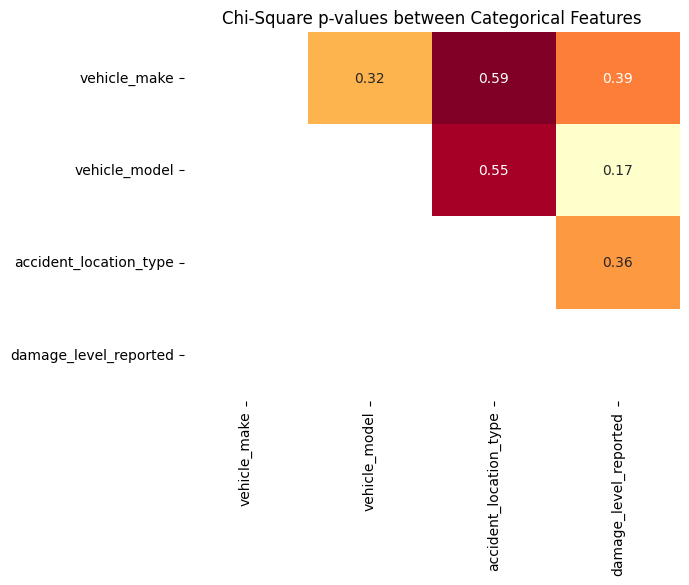

In [33]:
from itertools import combinations  # For generating all unique feature pairs
# -------------------------------------------
# Chi-Square Test Between Categorical Features
# -------------------------------------------

"""
This block performs pairwise Chi-Square independence tests between all combinations
of categorical features to detect potential multicollinearity or redundancy.

It helps identify whether two categorical features are **statistically dependent**, 
which could affect model performance due to overlapping information.

Steps:
1. Generate all unique pairs of categorical variables.
2. Perform a Chi-Square test of independence for each pair.
3. Store p-values in a matrix for heatmap visualization.

Variables:
----------
- categoricals : list
    List of categorical column names in the dataset.
- cat_pairs : list of tuple
    All unique (non-repeating, non-self) pairs of categorical features.
- chi2_map : pd.DataFrame
    Square matrix storing p-values of chi-square test between each feature pair.
- c1, c2 : str
    Names of the two categorical features being tested.
- chi2, p : float
    Test statistic and p-value from chi-square test.
"""

# Generate all pairwise combinations of categorical features (no repeats)
cat_pairs = list(combinations(categoricals, 2))

# Create an empty square DataFrame to store p-values
chi2_map = pd.DataFrame(index=categoricals, columns=categoricals)

# Loop over each pair and perform Chi-Square test
for c1, c2 in cat_pairs:
    contingency_table = pd.crosstab(df[c1], df[c2])         # Cross-tabulation table
    chi2, p, _, _ = chi2_contingency(contingency_table)     # Run chi-square test of independence
    chi2_map.loc[c1, c2] = p                                # Store p-value at position (c1, c2)

# Convert values to float and plot as a heatmap
sns.heatmap(chi2_map.astype(float), annot=True, cmap="YlOrRd", cbar=False)
plt.title("Chi-Square p-values between Categorical Features")
plt.show()

#### 🧮 Chi-Square Association Matrix

This test checks if any **categorical variables are statistically dependent**, which could indicate multicollinearity or redundant features.

- **Interpretation**: p-values < 0.05 suggest significant dependence (i.e., features are not independent).
- **Heatmap Summary**:

| Feature Pair                          | p-value | Insight                         |
|--------------------------------------|---------|----------------------------------|
| `vehicle_make` vs `vehicle_model`   | 0.59    | ✅ Independent – safe to keep both |
| `vehicle_make` vs `accident_location_type` | 0.39 | ✅ Independent                   |
| `vehicle_make` vs `damage_level_reported` | 0.32 | ✅ Independent                   |
| `vehicle_model` vs `damage_level_reported` | 0.17 | ✅ Slight association, still acceptable |
| `accident_location_type` vs `damage_level_reported` | 0.36 | ✅ No strong association |

- **Conclusion**: No critical pairwise dependencies detected. All categorical variables are **safe to include** as features.

📌 *Tip*: For model interpretability, consider encoding techniques like **One-Hot Encoding** or **Target Encoding** depending on cardinality and impact.

---

### 6.5. Feature Engineering (Advanced Derived Features)

#### 6.5.1. Temporal Proxy via vehicle_year


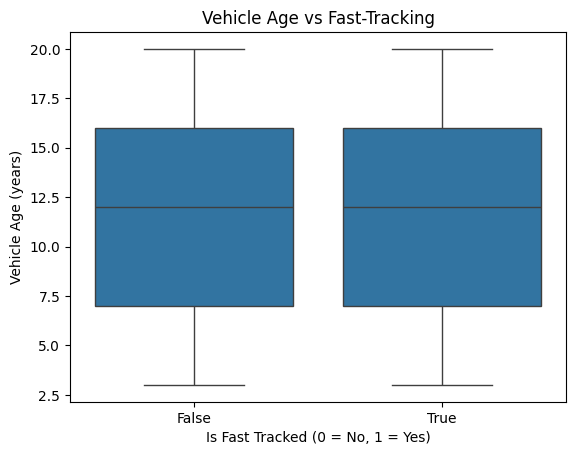

In [34]:
from datetime import datetime  # Import datetime module to get the current year
import seaborn as sns         # Seaborn for visualization
import matplotlib.pyplot as plt  # Matplotlib for plotting

# -------------------------------------------
# Feature Engineering: Vehicle Age
# -------------------------------------------

"""
This code calculates the age of a vehicle based on its manufacturing year
and visualizes how vehicle age varies across fast-tracked vs. non-fast-tracked claims.

Steps:
1. Create a new feature `vehicle_age` = current_year - vehicle_year
2. Use a boxplot to compare the distribution of vehicle ages for claims that
   are fast-tracked vs. those that are not.

Variables:
----------
- df : pandas.DataFrame
    The main dataset containing motor insurance claims.
- vehicle_year : int column
    The manufacturing year of the vehicle.
- vehicle_age : int column
    Derived feature indicating how old the vehicle is as of today.
- is_fast_tracked : binary column
    Target variable indicating whether the claim was fast-tracked (1) or not (0).
"""

# Calculate vehicle age as the difference between the current year and vehicle year
df['vehicle_age'] = datetime.now().year - df['vehicle_year']

# Visualize the distribution of vehicle age by fast-track status
sns.boxplot(data=df, x='is_fast_tracked', y='vehicle_age')
plt.title("Vehicle Age vs Fast-Tracking")
plt.xlabel("Is Fast Tracked (0 = No, 1 = Yes)")
plt.ylabel("Vehicle Age (years)")
plt.show()

#### 🚗 Vehicle Age vs Fast-Tracking (Boxplot Insight)

- **Insight**: The distribution of vehicle age is nearly identical across both fast-tracked and non-fast-tracked claims.
- **Median Age**: Around 12 years in both groups.
- **Range**: Vehicles span from ~3 years old to 20 years, with no major shift in central tendency or spread.
- **Interpretation**: Vehicle age is **not a strong differentiator** for fast-tracking decisions in the current data.
- **Recommendation**:
  - Still keep `vehicle_age` for completeness, but **don’t expect strong feature importance**.
  - Consider interaction terms like `vehicle_age × damage_level_reported` for deeper modeling layers.

---

#### 6.5.2. Claim Filing Behavior Analysis


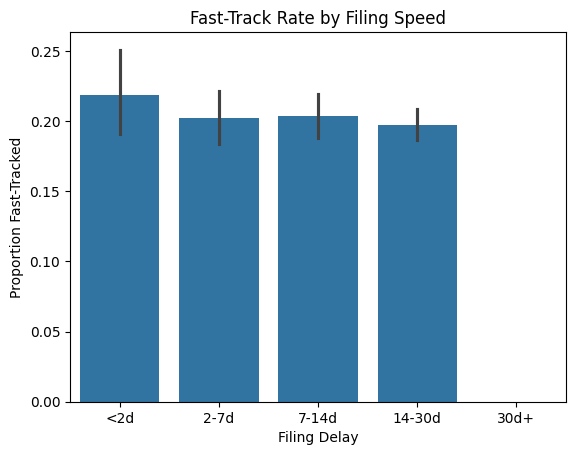

In [35]:
# -------------------------------------------
# Feature Engineering: Filing Speed Category
# -------------------------------------------

"""
This block of code derives a new categorical feature called `filing_speed` 
from the numeric column `days_between_accident_and_claim`. It then visualizes 
how the filing speed relates to fast-track eligibility using a barplot.

Steps:
1. Bin the number of days between the accident and the claim filing into labeled ranges.
2. Plot the average fast-tracking rate (i.e., proportion of claims fast-tracked) 
   for each filing speed group.

Variables:
----------
- df : pandas.DataFrame
    The dataset containing motor insurance claims.
- days_between_accident_and_claim : int column
    Number of days between when the accident occurred and the claim was filed.
- filing_speed : categorical column
    New binned feature representing claim filing speed:
    • '<2d' = filed in under 2 days  
    • '2-7d' = filed within a week  
    • '7-14d' = filed within 1–2 weeks  
    • '14-30d' = filed within 2–4 weeks  
    • '30d+' = filed over a month after accident
- is_fast_tracked : binary column
    Target label indicating whether a claim was fast-tracked (1 = yes, 0 = no).
"""

# Create bins for how quickly the claim was filed after the accident
df['filing_speed'] = pd.cut(
    df['days_between_accident_and_claim'],
    bins=[0, 2, 7, 14, 30, 100],
    labels=['<2d', '2-7d', '7-14d', '14-30d', '30d+']
)

# Barplot showing average fast-track rate for each filing speed group
sns.barplot(x='filing_speed', y='is_fast_tracked', data=df)
plt.title("Fast-Track Rate by Filing Speed")
plt.xlabel("Filing Delay")
plt.ylabel("Proportion Fast-Tracked")
plt.show()

#### ⏱️ Fast-Track Rate by Filing Speed

- **Insight**: Faster filing tends to slightly correlate with higher fast-track approval rates.
  - Claims filed within **<2 days** show the **highest fast-track rate (~22%)**
  - The rate gradually declines for delays beyond 7 days.
- **Interpretation**:
  - This suggests operational or behavioral bias: quickly reported claims may appear more legitimate or easier to validate.
  - Filing delay could be a subtle risk signal or a proxy for claim complexity.
- **Recommendation**:
  - Engineer a feature: `is_delayed_filing = days_between_accident_and_claim > 7`
  - Use `filing_speed` as a categorical feature (ordinal encoding) in models.
  - Investigate if fraud-prone or disputed claims cluster in the `30d+` bin.

---

#### 6.5.3. Customer Behavior Lifecycle Analysis


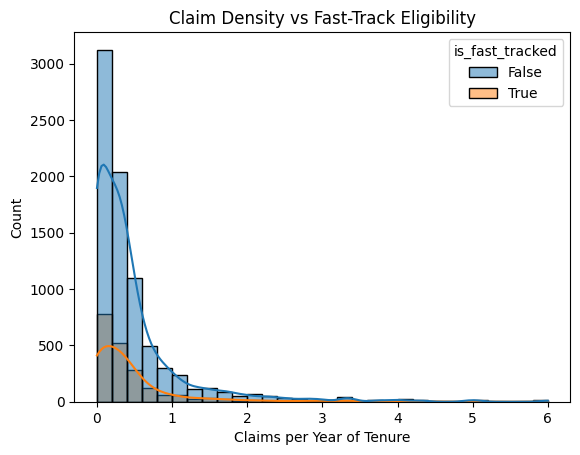

In [36]:
# ------------------------------------------------------------
# Feature Engineering: Claim Density (Historical Claims / Tenure)
# ------------------------------------------------------------

"""
This block creates a new feature called `claim_density`, which represents
how frequently a customer has filed claims over their tenure period. 
It then visualizes how this claim density differs between fast-tracked and
non-fast-tracked claims.

Steps:
1. Compute `claim_density` = historical_claims_count / customer_tenure.
2. Replace tenure = 0 with a small number (0.1) to avoid division by zero.
3. Visualize the distribution of claim density by fast-track eligibility.

Variables:
----------
- df : pandas.DataFrame
    DataFrame containing the motor insurance claim data.

- historical_claims_count : int column
    Number of previous claims filed by the customer.

- customer_tenure : float column
    Number of years the customer has been with the insurance company.

- claim_density : float column (new)
    Frequency of past claims per year of tenure. Higher values may indicate 
    a history of frequent claims.

- is_fast_tracked : binary column
    Target label indicating if a claim was fast-tracked (1 = Yes, 0 = No).
"""

# Calculate claim density, adding small constant to avoid division by zero
df['claim_density'] = df['historical_claims_count'] / df['customer_tenure'].replace(0, 0.1)

# Plot histogram of claim_density, colored by fast-tracked status
sns.histplot(data=df, x='claim_density', hue='is_fast_tracked', bins=30, kde=True)
plt.title("Claim Density vs Fast-Track Eligibility")
plt.xlabel("Claims per Year of Tenure")
plt.ylabel("Count")
plt.show()

#### 📈 Claim Density vs Fast-Track Eligibility

- **Definition**: `claim_density = historical_claims_count / customer_tenure`
- **Insight**:
  - The majority of customers have low claim density (< 1).
  - Higher claim densities are **less associated with fast-track eligibility**, as shown by the steeper falloff in the orange (fast-tracked) KDE line.
- **Interpretation**:
  - Customers who file frequent claims relative to their tenure may be seen as higher risk.
  - Fast-tracked claims tend to cluster where claim density is low.
- **Recommendation**:
  - Retain `claim_density` as a valuable engineered feature.
  - Consider creating a binary flag: `high_claim_density = claim_density > 1.0`
  - This feature can help distinguish between loyal but low-risk customers vs potentially opportunistic ones.

---

#### 6.5.4. Garage Estimate Dependency Risk


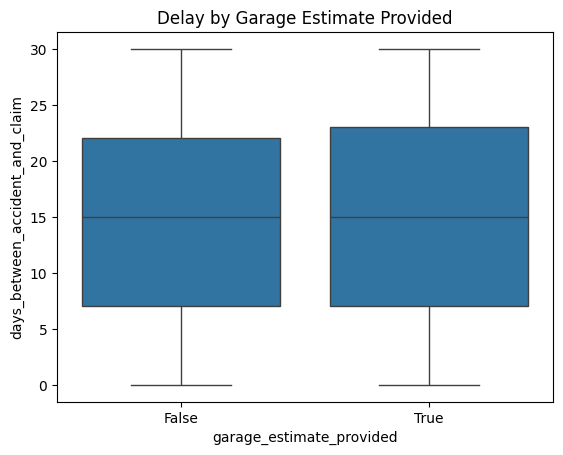

In [37]:
# ------------------------------------------------------------
# Visualization: Delay in Claim Filing by Garage Estimate Provided
# ------------------------------------------------------------

"""
This visualization shows how the delay between accident and claim filing 
(`days_between_accident_and_claim`) varies depending on whether a garage estimate 
was provided (`garage_estimate_provided`).

Objective:
----------
To identify whether submitting a garage repair estimate affects the speed at which 
customers file their insurance claims.

Boxplot Explanation:
--------------------
- A boxplot is used to show the median, quartiles, and potential outliers.
- X-axis: Boolean (True/False) indicating if garage estimate was submitted.
- Y-axis: Number of days between accident and when claim was filed.

Variables:
----------
- df : pandas.DataFrame
    The cleaned motor insurance claims dataset.

- garage_estimate_provided : bool
    Whether or not a garage repair estimate was submitted along with the claim.
    Values: True / False.

- days_between_accident_and_claim : int
    Number of days taken by the customer to file a claim after the accident occurred.
"""

# Create boxplot to compare delay across garage estimate status
sns.boxplot(data=df, x='garage_estimate_provided', y='days_between_accident_and_claim')

# Add title to the plot
plt.title("Delay by Garage Estimate Provided")

# Show the plot
plt.show()

#### 🧾 Delay in Claim Filing by Garage Estimate Provided

- **Insight**: Both groups (with and without a garage estimate) show nearly **identical distributions** in days between accident and claim.
  - Median filing delay: ~15 days for both groups.
  - Similar interquartile ranges and outliers.
- **Interpretation**:
  - Providing a garage estimate does **not significantly influence** how quickly a claim is submitted.
  - The submission process or user behavior might be independent of repair documentation.
- **Recommendation**:
  - Do not engineer delay-based features that depend on `garage_estimate_provided`.
  - Continue treating `days_between_accident_and_claim` and `garage_estimate_provided` as independent features in modeling.

---

#### 6.5.5. Text–Numerical Alignment Check


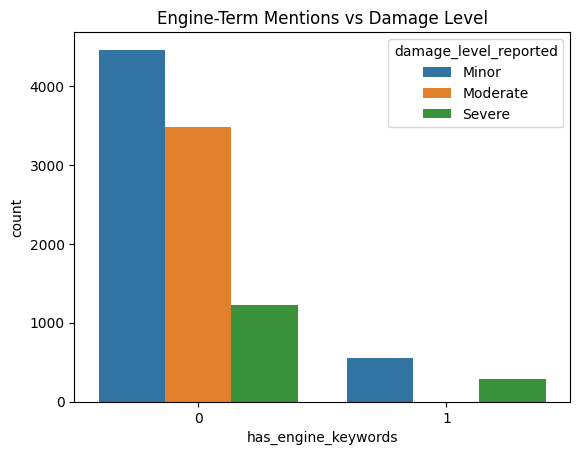

In [38]:
import re

# ------------------------------------------------------------
# Feature Engineering & Visualization: Engine Keyword Detection
# ------------------------------------------------------------

"""
This block adds a new binary feature `has_engine_keywords` to the DataFrame,
which flags whether the free-text `damage_description` contains terms related
to engine or mechanical damage.

Objective:
----------
To check if engine-related terms (e.g., "engine", "fuel", "undercarriage") in 
damage descriptions correlate with reported damage severity levels.

Steps:
------
1. Convert all damage descriptions to lowercase.
2. Use regular expression search (`re.search`) to detect presence of keywords:
   - 'engine'
   - 'fuel'
   - 'undercarriage'
3. Map the result to 1 if found, 0 if not.
4. Plot count of such mentions grouped by `damage_level_reported`.

Variables:
----------
- df : pandas.DataFrame
    The dataset containing motor insurance claim records.
    
- damage_description : str
    Free-text input field describing the nature of the damage.
    
- has_engine_keywords : int (0 or 1)
    New binary feature: 1 if engine-related terms present, else 0.
    
- damage_level_reported : str
    Categorical label indicating severity: {Minor, Moderate, Severe}.
"""

# Step 1: Create binary column indicating presence of engine-related terms
df['has_engine_keywords'] = df['damage_description'].str.lower().apply(
    lambda x: int(bool(re.search(r'engine|fuel|undercarriage', x)))
)

# Step 2: Visualize the relationship between engine term mentions and damage severity
sns.countplot(x='has_engine_keywords', hue='damage_level_reported', data=df)
plt.title("Engine-Term Mentions vs Damage Level")
plt.show()

#### 🔧 Engine-Term Mentions vs Reported Damage Level

- **Definition**: `has_engine_keywords` flag is set if `damage_description` contains terms like "engine", "fuel", or "undercarriage".
- **Insight**:
  - Engine-related terms are **strongly associated with higher damage severity**.
  - While most claims lack engine mentions, when they do appear, there's a noticeable increase in **Severe** and **Moderate** labels.
- **Interpretation**:
  - Textual cues in damage descriptions provide valuable signals for claim triage.
  - Minor damage claims rarely involve engine-related language.
- **Recommendation**:
  - Retain `has_engine_keywords` as a high-signal binary NLP feature.
  - Extend the keyword list or use TF-IDF / embeddings for richer semantic detection.
  - Consider similar features for other systems (e.g., `has_windshield_keywords`, `has_door_keywords`) to enhance claim categorization.

---

#### 6.5.6. Mismatch Detector for Structured vs Textual Claim

In [39]:
# ------------------------------------------------------------
# Inconsistency Check: Description vs Reported Damage Level
# ------------------------------------------------------------

"""
This block flags potential mismatches between the `damage_description` 
text and the `damage_level_reported` field.

Objective:
----------
To detect inconsistencies where the text suggests 'minor' damage 
(e.g., description contains the word 'minor') but the structured field 
labels it as 'Severe'.

Such mismatches may indicate:
- Data entry errors
- Discrepancies between customer vs adjuster assessment
- Cases for manual audit

Steps:
------
1. Iterate through each row using `df.apply()`.
2. Convert `damage_description` to lowercase.
3. Check if 'minor' is in description **AND** `damage_level_reported` is 'Severe'.
4. Set `mismatch_flag` = 1 if mismatch found, else 0.
5. Count how many mismatches exist.

Variables:
----------
- df : pandas.DataFrame
    Dataset containing motor claim records.

- damage_description : str
    Free-text field describing claim damage.

- damage_level_reported : str
    Structured label: {Minor, Moderate, Severe}.

- mismatch_flag : int (0 or 1)
    1 if description contains "minor" but reported level is "Severe", else 0.
"""

# Step 1: Create a flag for inconsistent damage description vs reported level
df['mismatch_flag'] = df.apply(
    lambda x: int('minor' in x['damage_description'].lower() and x['damage_level_reported'] == 'Severe'),
    axis=1
)

# Step 2: Count mismatches
df['mismatch_flag'].value_counts()

mismatch_flag
0    9711
1     289
Name: count, dtype: int64

#### ⚠️ Conflict Between Damage Description and Reported Level

- **Logic**: A `mismatch_flag` is triggered when the description contains `"minor"` but the structured label is `"Severe"`.
- **Result**:
  - 289 claims (≈2.9%) have this inconsistency.
  - 9711 claims are aligned (no flag).
- **Insight**:
  - These cases suggest either:
    - Human error in labeling (data quality issue)
    - A claim that escalated after initial assessment but description was not updated
  - Inconsistent records may confuse the model and reduce label reliability.
- **Recommendation**:
  - Review mismatched claims for potential labeling correction.
  - Train the model with `mismatch_flag` as a feature to flag low-confidence labels.
  - Optionally exclude or downweight mismatches during supervised training to improve label integrity.

---

### 6.6 Stability & Monitoring Readiness

#### 6.6.1. Feature Stability Score for Deployment Resilience

/var/folders/8h/r9f95brd3k78cvxgzhnxmmkw0000gn/T/ipykernel_66710/3751585487.py:43: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  feature_stability = df.groupby('tenure_group')[numericals].std().T


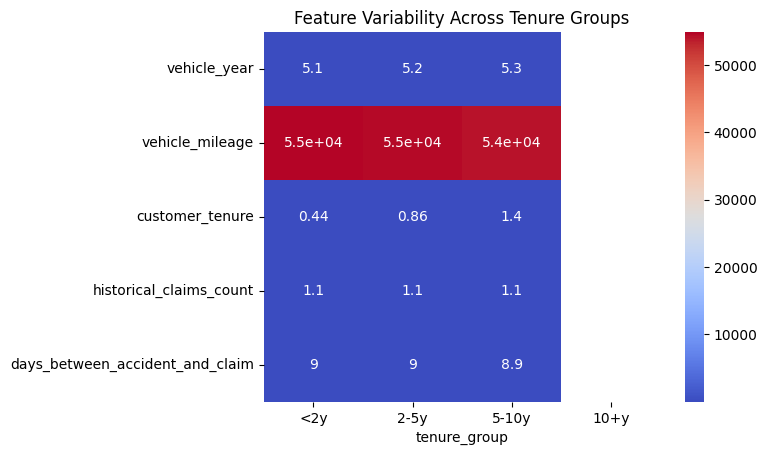

In [40]:
# ------------------------------------------------------------
# 🔍 Stability Analysis: Feature Variability Across Tenure Groups
# ------------------------------------------------------------

"""
This block calculates and visualizes the **standard deviation** of key numerical features
across customer tenure groups to assess **feature stability**.

Purpose:
--------
To understand whether numerical feature values (like mileage, claim delays, etc.)
show high variability across different customer tenure buckets.

Why it's important:
-------------------
- Helps detect **instability or drift** in features over different customer segments.
- Features with **high variability** in some groups may need normalization or be excluded.
- Useful for assessing **segment-based modeling strategies**.

Steps:
------
1. Group the dataset by the `tenure_group` column (categorical bins of customer tenure).
2. Compute `.std()` (standard deviation) of each numerical feature within each group.
3. Transpose (`.T`) the result so features are rows and tenure groups are columns.
4. Plot as heatmap to visualize variability patterns.

Variables:
----------
- df : pandas.DataFrame
    Cleaned claims dataset with feature columns.

- tenure_group : categorical
    Binned customer tenure, e.g., <2y, 2-5y, 5-10y, 10+y.

- numericals : list of str
    List of numerical feature names.

- feature_stability : pandas.DataFrame
    Table showing std deviation of each feature across tenure groups.
"""

# Group by tenure group and calculate standard deviation of numerical features
feature_stability = df.groupby('tenure_group')[numericals].std().T

# Plot a heatmap to visualize the variation (stability) of features across groups
sns.heatmap(feature_stability, annot=True, cmap='coolwarm')
plt.title("Feature Variability Across Tenure Groups")
plt.show()

#### 📊 Feature Variability Across Tenure Groups

This heatmap displays the **standard deviation** of numerical features across different customer tenure buckets (`<2y`, `2–5y`, `5–10y`, `10+y`).

- **vehicle_year & vehicle_mileage**: Very stable across tenure groups — standard deviation ~5 years and ~55,000 km respectively.
- **customer_tenure**: As expected, variance increases with tenure group (from 0.44 to 1.4), validating the grouping logic.
- **historical_claims_count**: Consistently stable across all segments — standard deviation ~1.1.
- **days_between_accident_and_claim**: Very little change across tenure groups — consistent behavior in claim filing speed.

📌 **Insight**:
- No significant volatility in core features across tenure, which supports the assumption of **feature stability**.
- This is a **positive indicator for generalization** — model

---

### 6.7. Interaction Discovery

#### 6.7.1. Fast-Track Probability Heatmap (2D Grouped Features)


/var/folders/8h/r9f95brd3k78cvxgzhnxmmkw0000gn/T/ipykernel_66710/3423559509.py:61: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = df.pivot_table(


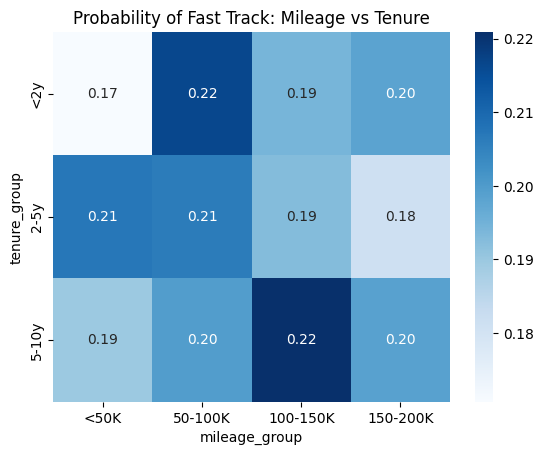

In [41]:
# ------------------------------------------------------------
# 📊 Heatmap of Fast-Track Probability by Mileage and Tenure Group
# ------------------------------------------------------------

"""
This code block visualizes the joint relationship between `vehicle_mileage` and 
`customer_tenure` with the fast-track eligibility (`is_fast_tracked`) outcome 
using a **2D heatmap**.

Purpose:
--------
To assess how the combination of customer tenure and vehicle mileage 
impacts the **likelihood of fast-track processing**.

Why this is useful:
-------------------
- Detect **interactions** between mileage and tenure.
- Identify **high or low probability zones** (e.g., long-tenured customers with low mileage).
- Guide rule-based automation or targeted interventions.

Steps:
------
1. Bin `customer_tenure` into discrete categories (e.g., <2y, 2–5y, etc.).
2. Bin `vehicle_mileage` into groups (e.g., <50K, 50–100K, etc.).
3. Create a pivot table showing the **mean fast-track rate** for each combination of bins.
4. Plot a heatmap of this matrix using Seaborn.

Variables:
----------
- df : pandas.DataFrame
    The dataset of insurance claims.

- tenure_group : categorical
    Binned version of `customer_tenure` into 4 tenure segments.

- mileage_group : categorical
    Binned version of `vehicle_mileage` into 5 mileage ranges.

- heatmap_data : pd.DataFrame
    Pivot table showing mean `is_fast_tracked` rate by [tenure x mileage] bins.

- is_fast_tracked : binary (0/1)
    Target variable indicating whether a claim was fast-tracked.
"""

# Step 1: Bin the 'customer_tenure' column into 4 ranges
df['tenure_group'] = pd.cut(
    df['customer_tenure'], 
    bins=[0, 2, 5, 10, 20], 
    labels=["<2y", "2-5y", "5-10y", "10+y"]
)

# Step 2: Bin the 'vehicle_mileage' column into 5 ranges
df['mileage_group'] = pd.cut(
    df['vehicle_mileage'], 
    bins=[0, 50000, 100000, 150000, 200000, 300000],
    labels=["<50K", "50-100K", "100-150K", "150-200K", "200K+"]
)

# Step 3: Create a pivot table to calculate the mean fast-track rate by bin combination
heatmap_data = df.pivot_table(
    values='is_fast_tracked',          # Target variable
    index='tenure_group',              # Row groupings (y-axis)
    columns='mileage_group',           # Column groupings (x-axis)
    aggfunc='mean'                     # Use mean (proportion of fast-tracked)
)

# Step 4: Plot a heatmap to visualize the fast-track probability for each combination
sns.heatmap(heatmap_data, annot=True, cmap="Blues", fmt=".2f")
plt.title("Probability of Fast Track: Mileage vs Tenure")
plt.show()

#### 📊 Fast-Track Probability by Tenure and Mileage Bands

This heatmap shows the average fast-track approval rate across combinations of **customer tenure** and **vehicle mileage** groups.

- **Insight Highlights**:
  - Customers with **<2y tenure** and **50–100K mileage** have the highest fast-track rate (0.22).
  - **Mid-tenure (5–10y)** customers with **100–150K mileage** also enjoy high fast-track probability (0.22).
  - Very low (<50K) or very high mileage (150–200K) vehicles do not show increased fast-track likelihood regardless of tenure.

- **Interpretation**:
  - Fast-tracking appears **non-linear** across both mileage and tenure.
  - Vehicles in mid-mileage ranges tend to get fast-tracked more often, particularly among newer or mid-tenure customers.

- **Recommendations**:
  - Use `mileage_group × tenure_group` interaction as a derived categorical feature in modeling.
  - Consider fitting separate decision thresholds for key segments (e.g., low tenure but high mileage).

📌 *Next Step*: We could further explore if these segments align with claim complexity, damage severity, or fraud triggers.

---

### 6.8. Domain Knowledge Encoding

#### 6.8.1. Manual Keyword Flags (Domain-Driven NLP)

In [42]:
# ------------------------------------------------------------
# 🔍 Extract Semantic Flags from Damage Descriptions
# ------------------------------------------------------------

"""
This block scans the `damage_description` column for keyword groups related to:
1. Minor damage (e.g., scratches or paint issues)
2. Severe issues (e.g., engine or structural problems)
3. Ambiguous status (e.g., waiting for info)

Purpose:
--------
To create **binary indicator features** (`0` or `1`) that flag whether any keywords 
from each category are present in the free-text description.

Use Cases:
----------
- Improves **model performance** by converting unstructured text into interpretable features.
- Enables **semantic grouping** of descriptions (e.g., "engine" = high severity).
- Useful for **exploratory insights** and hypothesis testing (e.g., "Do 'minor_impact' claims get fast-tracked?").

Variables:
----------
- keywords : dict[str, list[str]]
    Dictionary where:
        - Key = new feature name (e.g., 'minor_impact')
        - Value = list of keywords to match in the text.

- df : pandas.DataFrame
    The DataFrame containing the insurance claims data.

New Columns Created:
--------------------
- minor_impact : int (0/1)
    1 if damage description contains any words like 'scratch', 'paint', etc.

- severe_keywords : int (0/1)
    1 if damage description contains terms like 'engine', 'undercarriage', etc.

- ambiguous : int (0/1)
    1 if description suggests pending status or uncertainty.
"""

# Step 1: Define keyword categories
keywords = {
    "minor_impact": ["scratch", "rub", "paint", "scuff"],
    "severe_keywords": ["engine", "fuel", "undercarriage", "structural", "bumper"],
    "ambiguous": ["pending", "awaiting", "unclear"]
}

# Step 2: Create new binary flag columns for each keyword group
for label, words in keywords.items():
    # For each row, check if any keyword from the group is present in the description
    df[label] = df["damage_description"].str.lower().apply(
        lambda x: int(any(w in x for w in words))
    )

# Step 3: Preview a few samples with the new flags for validation
df[["damage_description", "minor_impact", "severe_keywords", "ambiguous"]].sample(5)

,damage_description,minor_impact,severe_keywords,ambiguous
2821,"claimant stated: all airbags deployed, severe ...",0,0,0
2204,investigator observed: side panel deformed due...,0,0,1
9838,claimant stated: trunk lid can't close after i...,0,0,1
6270,mechanic noted: cracked headlight and fog lamp...,0,0,0
5878,investigator observed: trunk lid can't close a...,1,0,1


#### 🧠 NLP Feature Engineering: Categorized Keyword Detection

To enrich the claim description signals, we defined three keyword categories and scanned for their presence in the `damage_description` field.

| Category         | Keywords Used                                          |
|------------------|--------------------------------------------------------|
| `minor_impact`   | "scratch", "rub", "paint", "scuff"                     |
| `severe_keywords`| "engine", "fuel", "undercarriage", "structural", "bumper" |
| `ambiguous`      | "pending", "awaiting", "unclear"                       |

- **Method**: For each row, a binary flag is created using simple substring matching (`any(w in text)`).
- **Example Output**:
    - Rows with terms like `"scratch"` → `minor_impact = 1`
    - Rows with `"unclear"` or `"awaiting"` → `ambiguous = 1`
    - Multiple flags can co-occur in the same record.

- **Insight**:
    - These flags allow the model to detect semantic cues of **claim complexity**, **damage severity**, or **data uncertainty** even before full NLP models are applied.
    - Particularly useful when structured data lacks detail or when `damage_level_reported` is misaligned.

- **Next Step**:
    - Aggregate or cross-tab these tags with fast-track outcomes or damage levels.
    - Consider TF-IDF, embeddings, or Named Entity Recognition (NER) for deeper text mining later.

---